# Expore data

## Import & definitions

In [228]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 12*6 # 6 hours used to predict next values in future
FUTURE_TARGET = 15 # number of 5 min to predict  : 12 + 3
STEP = 1
BATCH_SIZE = 32

TRAIN_SPLIT_RATIO = 0.99

path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

In [229]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [230]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        plt.savefig(os.path.join(saveFolder, f"output_{title}.jpg")) 
    plt.show()

## Load raw features

In [231]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_23856/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
50972  1687822800000   1855.62   1855.62  1855.16    1855.54    201.9601   
50973  1687823100000   1855.53   1858.85  1855.53    1858.81    600.4780   
50974  1687823400000   1858.80   1860.07  1858.80    1859.37    710.0421   
50975  1687823700000   1859.38   1859.38  1858.97    1858.97    220.7829   
50976  1687824000000   1858.97   1859.00  1856.85    1858.64   1226.9373   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1718.529243       1717.870567   
1      2023-01-01 00:05:00       1718.529243       1717.870567   
2      2023-01-01 00:10:00       1718.529243       1717.870567   
3      2023-01-01 00:15:00       1718.529243       1717.870567   
4      2023-01-01 00:20:00       1718.529243       1717.870567   
...                    ...               ...               ...   
50972  2023-06-26 23:40:00       1852.302500       1847.770000   
50973  2023-06-26 23:45:00       1852.432500       1850.235000   
50974  2023-06-26 23:50:00       1853.505000       1850.235000   
50975  2023-06-26 23:55:00       1853.505000       1850.235000   
50976  2023-06-27 00:00:00       1853.570000       1850.235000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
50972         1853.72  ...   NaN         NaN            NaN           NaN   
50973         1853.72  ...   NaN         NaN            NaN           NaN   
50974         1853.72  ...   NaN         NaN            NaN           NaN   
50975         1853.72  ...   NaN         NaN            NaN           NaN   
50976         1853.72  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
50972               NaN         0.0               NaN         0.0      0.0   
50973               NaN         0.0               NaN         0.0      0.0   
50974               NaN         0.0               NaN         0.0      0.0   
50975               NaN         0.0               NaN         0.0      0.0   
50976               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
50972   NaN  
50973   NaN  
50974   NaN  
50975   NaN  
50976   NaN  

[50977 rows x 135 columns]

### drop nan

In [232]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [233]:
df_feat = df_feat_raw.copy()

In [234]:
df_feat = df_feat.bfill(axis ='rows')

In [235]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
50972  1687822800000   1855.62   1855.62  1855.16    1855.54    201.9601   
50973  1687823100000   1855.53   1858.85  1855.53    1858.81    600.4780   
50974  1687823400000   1858.80   1860.07  1858.80    1859.37    710.0421   
50975  1687823700000   1859.38   1859.38  1858.97    1858.97    220.7829   
50976  1687824000000   1858.97   1859.00  1856.85    1858.64   1226.9373   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1718.529243       1717.870567   
1      2023-01-01 00:05:00       1718.529243       1717.870567   
2      2023-01-01 00:10:00       1718.529243       1717.870567   
3      2023-01-01 00:15:00       1718.529243       1717.870567   
4      2023-01-01 00:20:00       1718.529243       1717.870567   
...                    ...               ...               ...   
50972  2023-06-26 23:40:00       1852.302500       1847.770000   
50973  2023-06-26 23:45:00       1852.432500       1850.235000   
50974  2023-06-26 23:50:00       1853.505000       1850.235000   
50975  2023-06-26 23:55:00       1853.505000       1850.235000   
50976  2023-06-27 00:00:00       1853.570000       1850.235000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
50972         1853.72  ...   NaN         NaN            NaN           NaN   
50973         1853.72  ...   NaN         NaN            NaN           NaN   
50974         1853.72  ...   NaN         NaN            NaN           NaN   
50975         1853.72  ...   NaN         NaN            NaN           NaN   
50976         1853.72  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
50972               NaN         0.0               NaN         0.0      0.0   
50973               NaN         0.0               NaN         0.0      0.0   
50974               NaN         0.0               NaN         0.0      0.0   
50975               NaN         0.0               NaN         0.0      0.0   
50976               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
50972                  NaN  
50973                  NaN  
50974                  NaN  
50975                  NaN  
50976                  NaN  

[50977 rows x 135 columns]

In [236]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       2244
delta_event_real    2244
delta_event_pred    2244
Previous_num        2244
Actual_num          2244
Event               2244
Date                2244
Previous            2244
Consensus           2244
Actual              2244
Country             2244
Time (ET)           2244
keep                2244
date                2244
dtype: int64

on 50977 samples


In [237]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [238]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [239]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [240]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
50972   1855.62   1855.62  1855.16    1855.54    201.9601   
50973   1855.53   1858.85  1855.53    1858.81    600.4780   
50974   1858.80   1860.07  1858.80    1859.37    710.0421   
50975   1859.38   1859.38  1858.97    1858.97    220.7829   
50976   1858.97   1859.00  1856.85    1858.64   1226.9373   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1718.529243       1717.870567   
1      2023-01-01 00:05:00       1718.529243       1717.870567   
2      2023-01-01 00:10:00       1718.529243       1717.870567   
3      2023-01-01 00:15:00       1718.529243       1717.870567   
4      2023-01-01 00:20:00       1718.529243       1717.870567   
...                    ...               ...               ...   
50972  2023-06-26 23:40:00       1852.302500       1847.770000   
50973  2023-06-26 23:45:00       1852.432500       1850.235000   
50974  2023-06-26 23:50:00       1853.505000       1850.235000   
50975  2023-06-26 23:55:00       1853.505000       1850.235000   
50976  2023-06-27 00:00:00       1853.570000       1850.235000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71         1194.710  ...  1196.096667  1196.096667   
1             1194.71         1194.710  ...  1195.801420  1195.801420   
2             1194.71         1194.710  ...  1195.648641  1195.648641   
3             1194.71         1194.710  ...  1195.575250  1195.575250   
4             1194.71         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
50972         1853.72         1856.975  ...  1789.763954  1828.032752   
50973         1853.72         1856.860  ...  1789.761718  1828.030180   
50974         1853.72         1857.410  ...  1789.762917  1828.015099   
50975         1853.72         1857.615  ...  1789.759237  1828.005054   
50976         1853.72         1857.615  ...  1789.768974  1827.988470   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
50972  1838.952405  1820.051213   1712.762494          0.773285  0.076947   
50973  1838.956465  1820.052982   1712.763550          0.790993  0.078570   
50974  1838.962944  1820.055445   1712.764814          0.794022  0.078847   
50975  1838.965887  1820.056581   1712.765206          0.791857  0.078648   
50976  1838.976513  1820.061044   1712.767372          0.790061  0.078484   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205585e+08      279900.0       17.807301  
1      1.205585e+08      279900.0       17.807301  
2      1.205585e+08      279900.0       17.807301  
3      1.205585e+08      279900.0       17.807301  
4      1.205585e+08      279900.0       17.807301  
...             ...           ...             ...  
50972  1.199697e+08      406678.0       19.029543  
50973  1.199697e+08      406678.0       19.029543  
50974  1.199697e+08      406678.0       19.029543  
50975  1.199697e+08      406678.0       19.029543  
50976  1.199697e+08      406678.0       19.029543  

[50977 rows x 46 columns]

In [241]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [242]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [243]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [244]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [245]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [246]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [247]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [248]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [249]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [250]:
df_feat.shape[0]

50977

In [251]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

50467

In [252]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
50972  1687822800000   1855.62   1855.62  1855.16    1855.54    201.9601   
50973  1687823100000   1855.53   1858.85  1855.53    1858.81    600.4780   
50974  1687823400000   1858.80   1860.07  1858.80    1859.37    710.0421   
50975  1687823700000   1859.38   1859.38  1858.97    1858.97    220.7829   
50976  1687824000000   1858.97   1859.00  1856.85    1858.64   1226.9373   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1718.529243       1717.870567   
1      2023-01-01 00:05:00       1718.529243       1717.870567   
2      2023-01-01 00:10:00       1718.529243       1717.870567   
3      2023-01-01 00:15:00       1718.529243       1717.870567   
4      2023-01-01 00:20:00       1718.529243       1717.870567   
...                    ...               ...               ...   
50972  2023-06-26 23:40:00       1852.302500       1847.770000   
50973  2023-06-26 23:45:00       1852.432500       1850.235000   
50974  2023-06-26 23:50:00       1853.505000       1850.235000   
50975  2023-06-26 23:55:00       1853.505000       1850.235000   
50976  2023-06-27 00:00:00       1853.570000       1850.235000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
50972         1853.72  ...         NaN            NaN           NaN   
50973         1853.72  ...         NaN            NaN           NaN   
50974         1853.72  ...         NaN            NaN           NaN   
50975         1853.72  ...         NaN            NaN           NaN   
50976         1853.72  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
50972               NaN         0.0               NaN         0.0      0.0   
50973               NaN         0.0               NaN         0.0      0.0   
50974               NaN         0.0               NaN         0.0      0.0   
50975               NaN         0.0               NaN         0.0      0.0   
50976               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
50972                  NaN  False  
50973                  NaN  False  
50974                  NaN  False  
50975                  NaN  False  
50976                  NaN  False  

[50977 rows x 136 columns]

In [253]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
50463  1687670100000   1909.94   1910.93  1907.74    1908.00   1493.1311   
50464  1687670400000   1908.00   1914.24  1907.52    1911.58   2471.2582   
50465  1687670700000   1911.59   1913.99  1911.20    1912.60   1481.3984   
50466  1687671000000   1912.59   1913.84  1910.68    1911.93   1322.6147   
50467  1687671300000   1911.93   1915.68  1911.93    1915.20   2050.5771   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1718.529243       1717.870567   
1      2023-01-01 00:05:00       1718.529243       1717.870567   
2      2023-01-01 00:10:00       1718.529243       1717.870567   
3      2023-01-01 00:15:00       1718.529243       1717.870567   
4      2023-01-01 00:20:00       1718.529243       1717.870567   
...                    ...               ...               ...   
50463  2023-06-25 05:15:00       1880.272500       1877.640000   
50464  2023-06-25 05:20:00       1880.657500       1877.910000   
50465  2023-06-25 05:25:00       1881.280000       1877.910000   
50466  2023-06-25 05:30:00       1883.187500       1878.315000   
50467  2023-06-25 05:35:00       1883.675000       1878.605000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
50463        1900.215  ...         NaN            NaN           NaN   
50464        1900.215  ...         NaN            NaN           NaN   
50465        1900.925  ...         NaN            NaN           NaN   
50466        1901.560  ...         NaN            NaN           NaN   
50467        1901.745  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
50463               NaN         0.0               NaN         0.0      0.0   
50464               NaN         0.0               NaN         0.0      0.0   
50465               NaN         0.0               NaN         0.0      0.0   
50466               NaN         0.0               NaN         0.0      0.0   
50467               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
50463                  NaN   True  
50464                  NaN   True  
50465                  NaN   True  
50466                  NaN   True  
50467                  NaN   True  

[50468 rows x 136 columns]

In [254]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
50468  1687671600000   1915.21   1917.89  1915.00    1916.55   1921.6906   
50469  1687671900000   1916.55   1918.79  1913.74    1914.45   1420.1601   
50470  1687672200000   1914.46   1914.46  1912.00    1912.32    953.4947   
50471  1687672500000   1912.31   1912.51  1911.58    1911.73    651.4540   
50472  1687672800000   1911.72   1913.77  1908.44    1908.46   1690.2780   
...              ...       ...       ...      ...        ...         ...   
50972  1687822800000   1855.62   1855.62  1855.16    1855.54    201.9601   
50973  1687823100000   1855.53   1858.85  1855.53    1858.81    600.4780   
50974  1687823400000   1858.80   1860.07  1858.80    1859.37    710.0421   
50975  1687823700000   1859.38   1859.38  1858.97    1858.97    220.7829   
50976  1687824000000   1858.97   1859.00  1856.85    1858.64   1226.9373   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
50468  2023-06-25 05:40:00         1885.4125          1880.015   
50469  2023-06-25 05:45:00         1885.4975          1880.015   
50470  2023-06-25 05:50:00         1885.4975          1880.015   
50471  2023-06-25 05:55:00         1886.5225          1880.820   
50472  2023-06-25 06:00:00         1888.5175          1882.760   
...                    ...               ...               ...   
50972  2023-06-26 23:40:00         1852.3025          1847.770   
50973  2023-06-26 23:45:00         1852.4325          1850.235   
50974  2023-06-26 23:50:00         1853.5050          1850.235   
50975  2023-06-26 23:55:00         1853.5050          1850.235   
50976  2023-06-27 00:00:00         1853.5700          1850.235   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
50468        1903.525  ...         NaN            NaN           NaN   
50469        1903.975  ...         NaN            NaN           NaN   
50470        1904.375  ...         NaN            NaN           NaN   
50471        1905.545  ...         NaN            NaN           NaN   
50472        1906.925  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
50972        1853.720  ...         NaN            NaN           NaN   
50973        1853.720  ...         NaN            NaN           NaN   
50974        1853.720  ...         NaN            NaN           NaN   
50975        1853.720  ...         NaN            NaN           NaN   
50976        1853.720  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
50468               NaN         0.0               NaN         0.0      0.0   
50469               NaN         0.0               NaN         0.0      0.0   
50470               NaN         0.0               NaN         0.0      0.0   
50471               NaN         0.0               NaN         0.0      0.0   
50472               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
50972               NaN         0.0               NaN         0.0      0.0   
50973               NaN         0.0               NaN         0.0      0.0   
50974               NaN         0.0               NaN         0.0      0.0   
50975               NaN         0.0               NaN         0.0      0.0   
50976               NaN         0.0               NaN         0.0      0.0   

       date  train  
50468   NaN  False  
50469   NaN  False  
50470   NaN  False  
50471   NaN  False  
50472   NaN  False  
...     ...    ...  
50972   NaN  False  
50973   NaN  False  
50974   NaN  False  
50975   NaN  False  
50976   NaN  False  

[509 rows x 136 columns]

In [255]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [256]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [257]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [258]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50381, 72, 104) (50381, 15)
(422, 72, 104) (422, 15)


In [259]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [260]:
seq_y

array([0.99952276, 1.00240716, 1.00274805, 1.00383887, 1.00029893,
       0.99997378, 0.99926055, 0.99977449, 1.00096496, 0.99891966,
       1.00164148, 1.00062408, 1.00250156, 1.00303649, 1.00268511])

In [261]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00223869, 1.00441417, 1.00393483, ..., 1.0060629 , 1.00504101,
        1.00692678],
       [1.00217062, 1.00169235, 1.00458301, ..., 1.00279606, 1.00467761,
        1.0052137 ],
       [0.99952276, 1.00240716, 1.00274805, ..., 1.00250156, 1.00303649,
        1.00268511]])

In [262]:
seq_y

array([0.99952276, 1.00240716, 1.00274805, 1.00383887, 1.00029893,
       0.99997378, 0.99926055, 0.99977449, 1.00096496, 0.99891966,
       1.00164148, 1.00062408, 1.00250156, 1.00303649, 1.00268511])

In [263]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00223869, 1.00441417, 1.00393483, ..., 1.0060629 , 1.00504101,
        1.00692678],
       [1.00217062, 1.00169235, 1.00458301, ..., 1.00279606, 1.00467761,
        1.0052137 ],
       [0.99952276, 1.00240716, 1.00274805, ..., 1.00250156, 1.00303649,
        1.00268511]])

In [264]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [265]:
X_train.shape

(50381, 72, 104)

In [266]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(50381, 72, 104) (50381, 15)
(422, 72, 104) (422, 15)


## Standardization

In [267]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [268]:
#scaler_y = StandardScaler()
#y_train_sca = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
#y_test_sca = scaler_y.transform(y_test.reshape(-1,y_test.shape[-1])).reshape(y_test.shape)

scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [269]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00223869, 1.00441417, 1.00393483, ..., 1.0060629 , 1.00504101,
        1.00692678],
       [1.00217062, 1.00169235, 1.00458301, ..., 1.00279606, 1.00467761,
        1.0052137 ],
       [0.99952276, 1.00240716, 1.00274805, ..., 1.00250156, 1.00303649,
        1.00268511]])

In [270]:
np.mean(y_train_sca)

2.1265124387362453e-14

In [271]:
np.std(y_train_sca)

1.0

In [272]:
np.mean(y_test_sca)

-0.15001685601275933

In [273]:
np.std(y_test_sca)

0.9268181848236668

### Check unscaling

In [274]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1718.529243       1717.870567   
1    1195.38   1196.31   1196.69  1194.90       1718.529243       1717.870567   
2    1194.55   1195.38   1195.81  1194.55       1718.529243       1717.870567   
3    1195.98   1194.55   1195.98  1194.31       1718.529243       1717.870567   
4    1196.06   1195.98   1196.37  1195.97       1718.529243       1717.870567   
5    1196.61   1196.06   1196.70  1196.06       1718.529243       1717.870567   
6    1194.36   1196.62   1196.62  1193.72       1718.529243       1717.870567   
7    1194.22   1194.37   1194.43  1192.72       1718.529243       1717.870567   
8    1193.64   1194.22   1194.22  1193.02       1718.529243       1717.870567   
9    1194.64   1193.64   1195.06  1193.63       1718.529243       1717.870567   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1722.050038   
1         1194.71          1194.71           1722.050038   
2         1194.71          1194.71           1722.050038   
3         1194.71          1194.71           1722.050038   
4         1194.71          1194.71           1722.050038   
5         1194.71          1194.71           1722.050038   
6         1194.71          1194.71           1722.050038   
7         1194.71          1194.71           1722.050038   
8         1194.71          1194.71           1722.050038   
9         1194.71          1194.71           1722.050038   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0           1709.991759  ...       0.0      0.62349    -0.781831   
1           1709.991759  ...       0.0      0.62349    -0.781831   
2           1709.991759  ...       0.0      0.62349    -0.781831   
3           1709.991759  ...       0.0      0.62349    -0.781831   
4           1709.991759  ...       0.0      0.62349    -0.781831   
5           1709.991759  ...       0.0      0.62349    -0.781831   
6           1709.991759  ...       0.0      0.62349    -0.781831   
7           1709.991759  ...       0.0      0.62349    -0.781831   
8           1709.991759  ...       0.0      0.62349    -0.781831   
9           1709.991759  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [275]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [276]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [277]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [278]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [279]:
X_train_sca.shape

(50381, 72, 104)

In [280]:
X_train_sca[:,-1,:].shape

(50381, 104)

In [281]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08514324],
       [-0.03609482],
       [-0.19138263],
       ...,
       [ 0.48756735],
       [ 0.47216311],
       [-0.12705198]])

In [282]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(50381, 105)

In [283]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [284]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [285]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

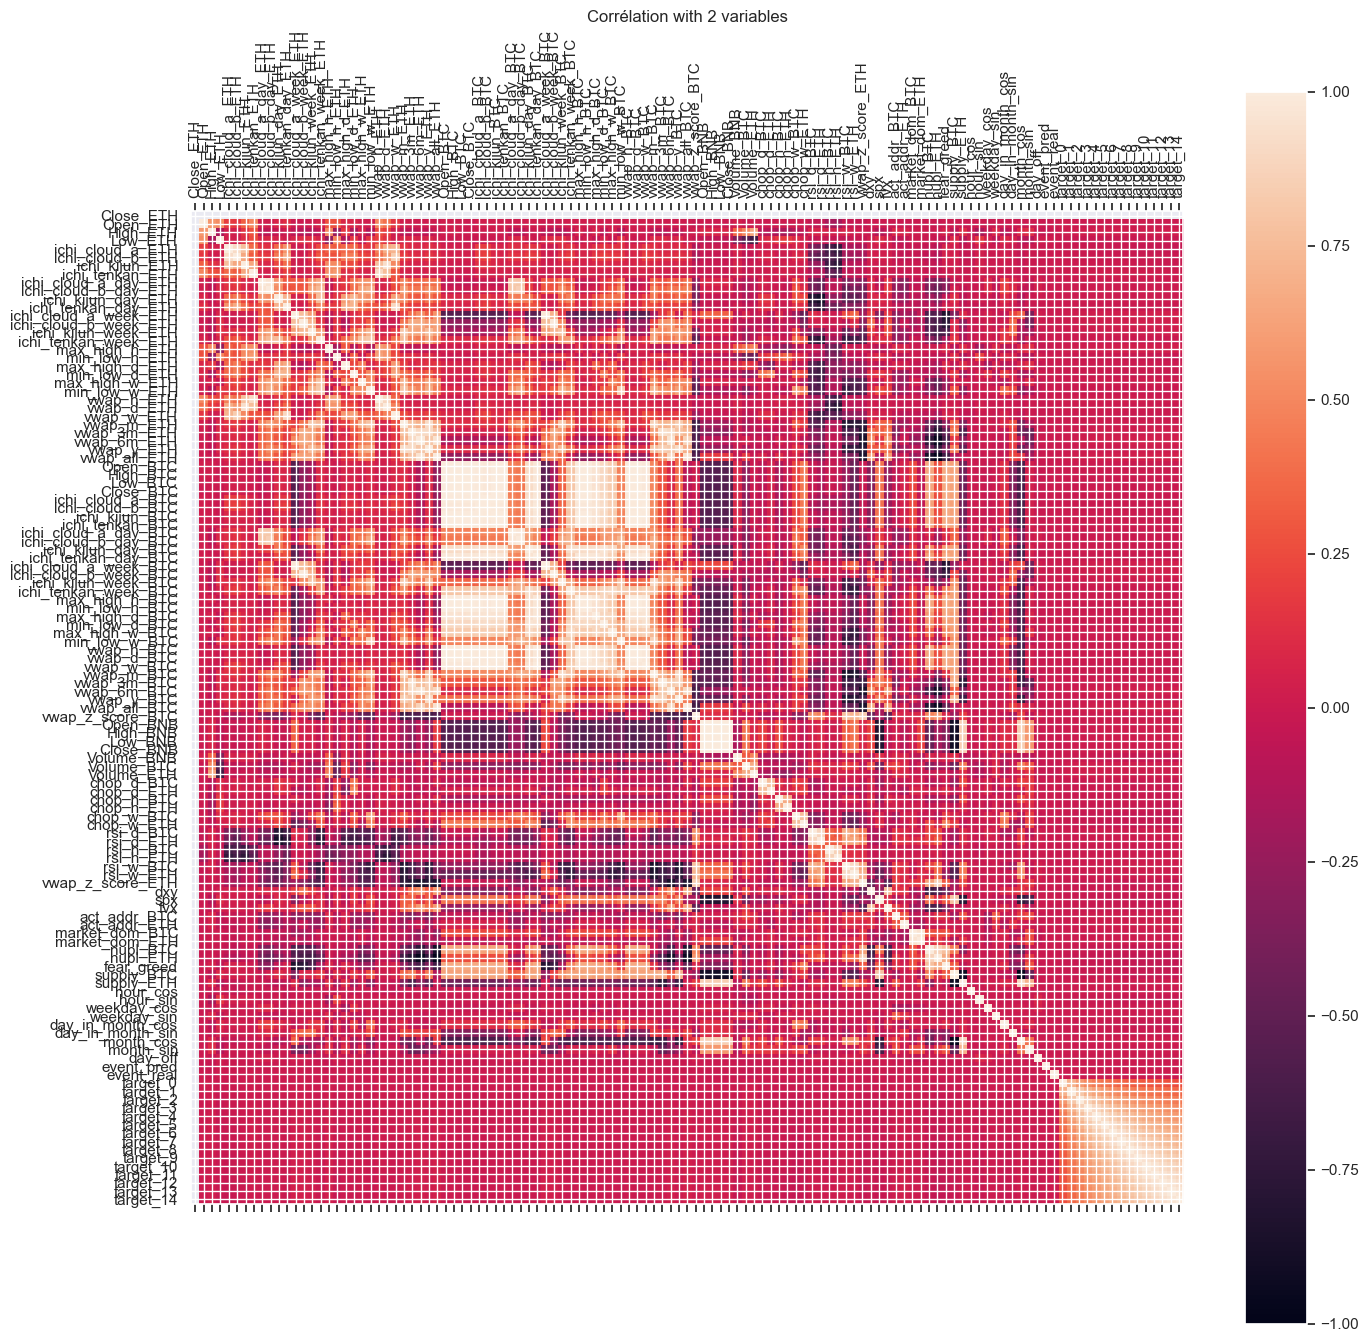

In [286]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


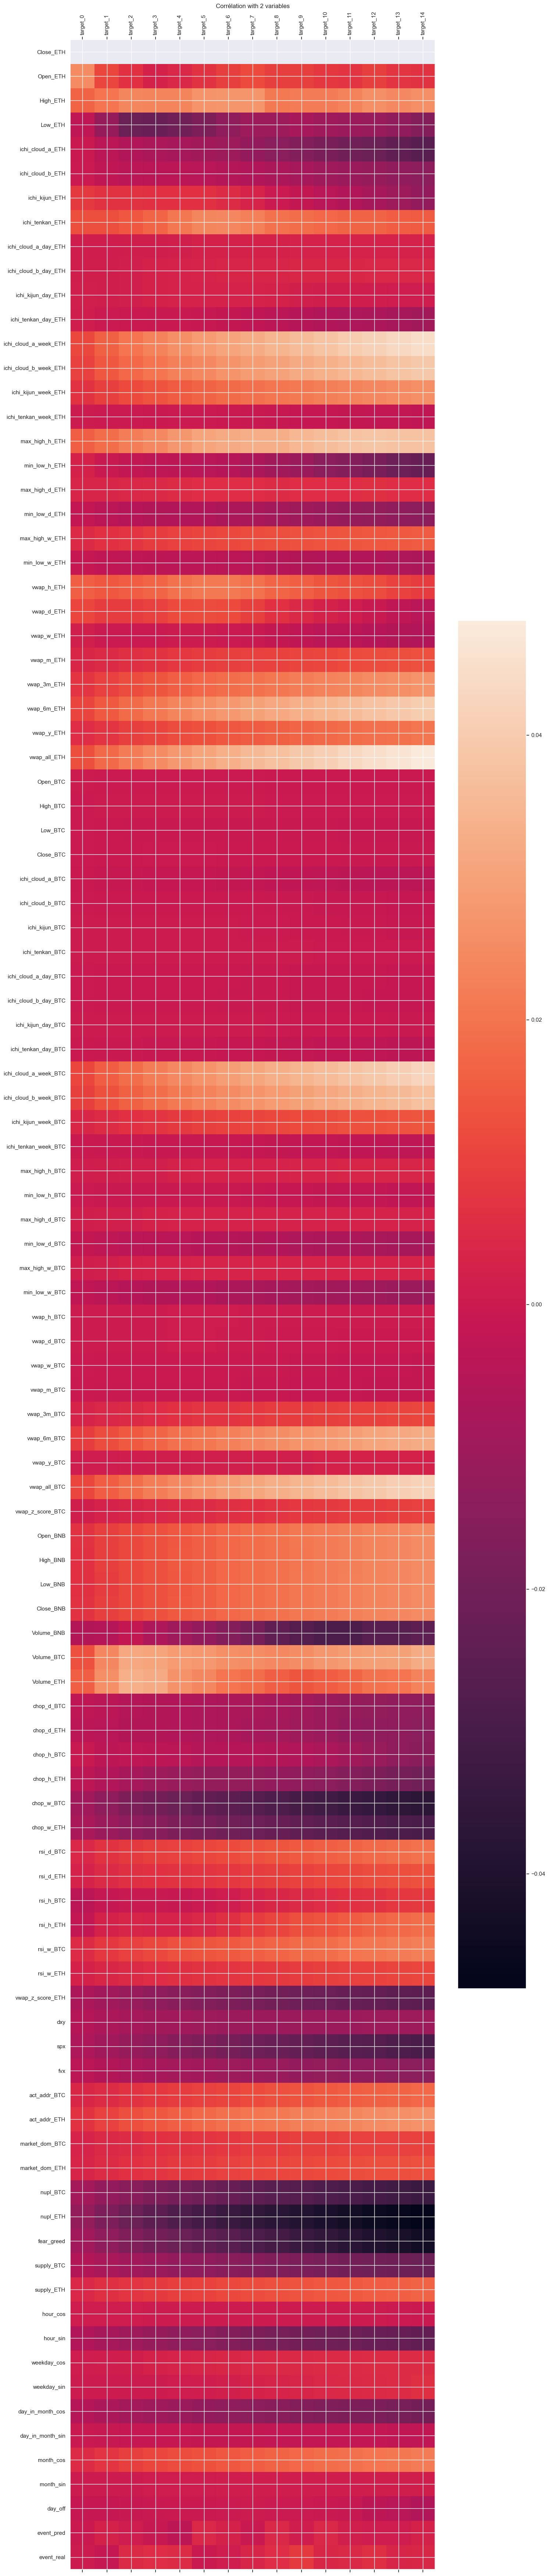

In [287]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


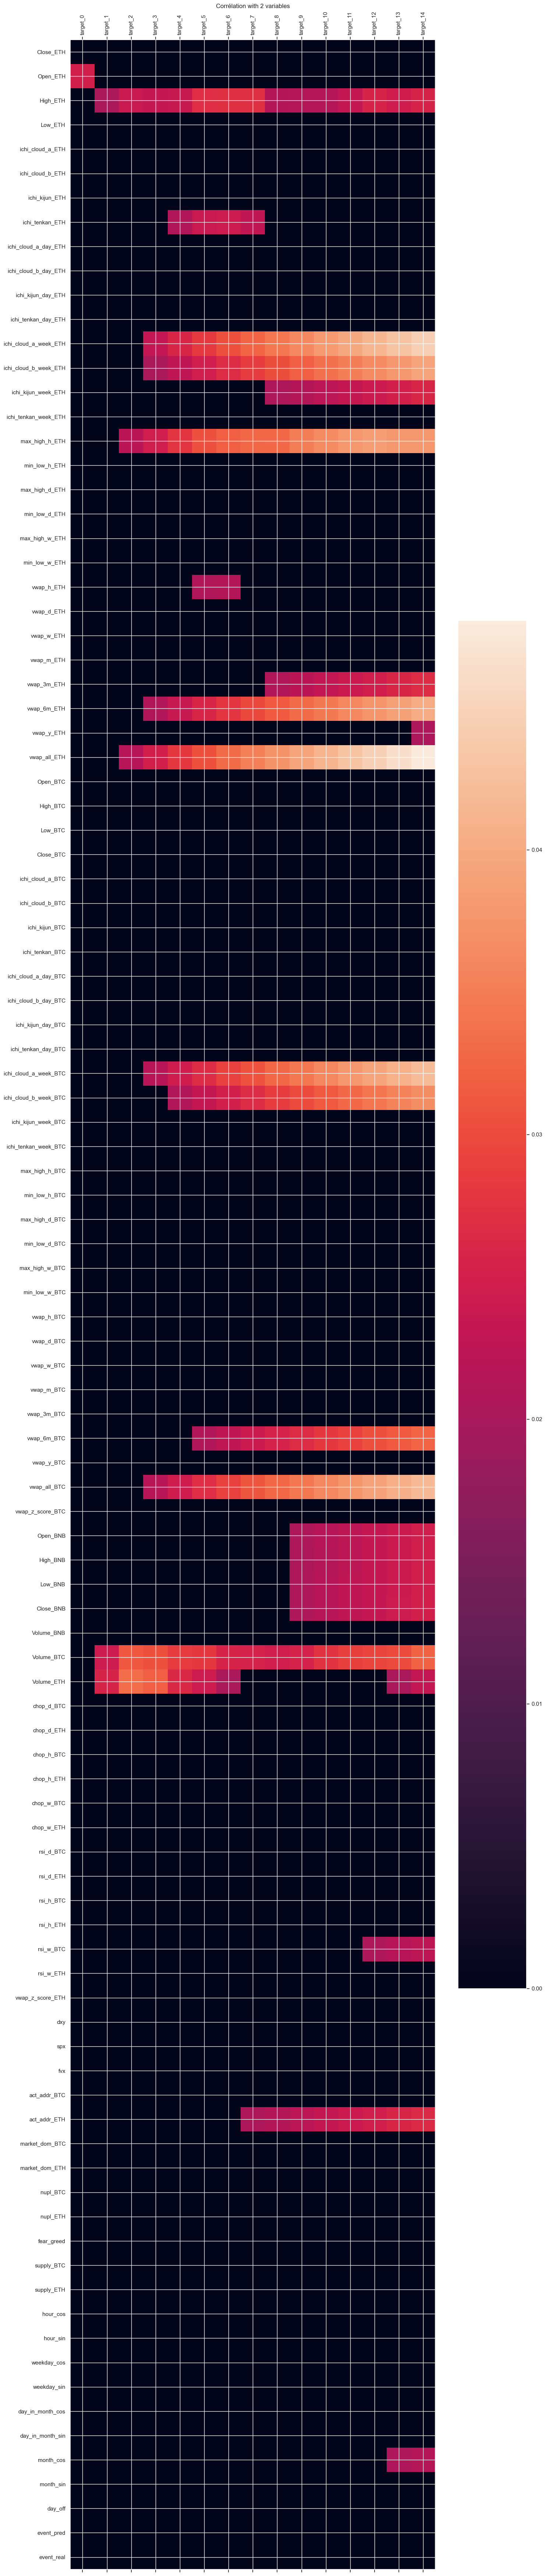

In [288]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [289]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

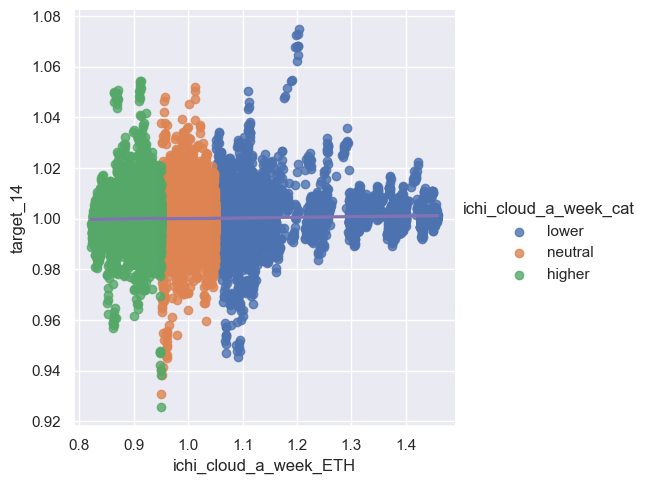

In [290]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

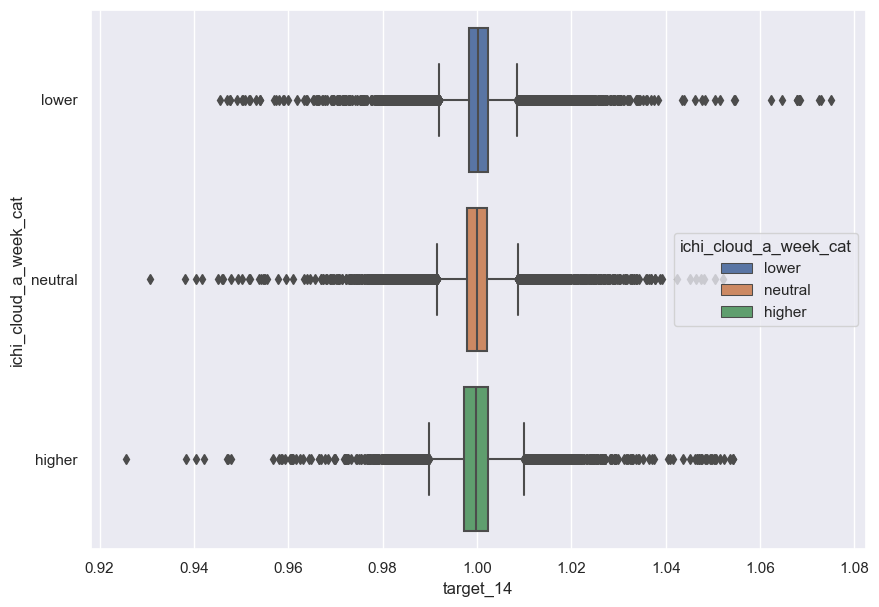

In [291]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [292]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


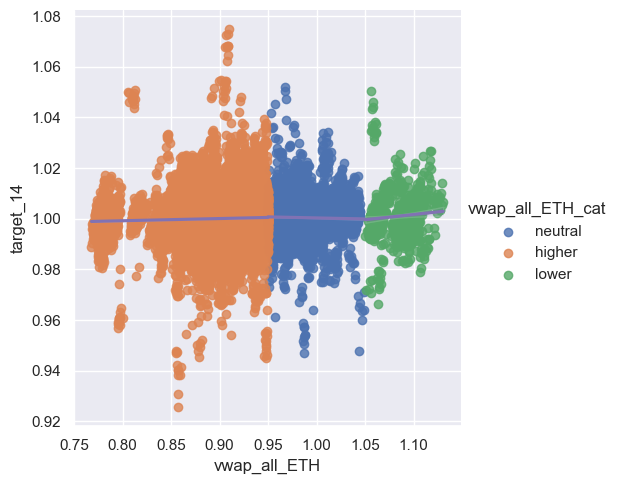

In [293]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

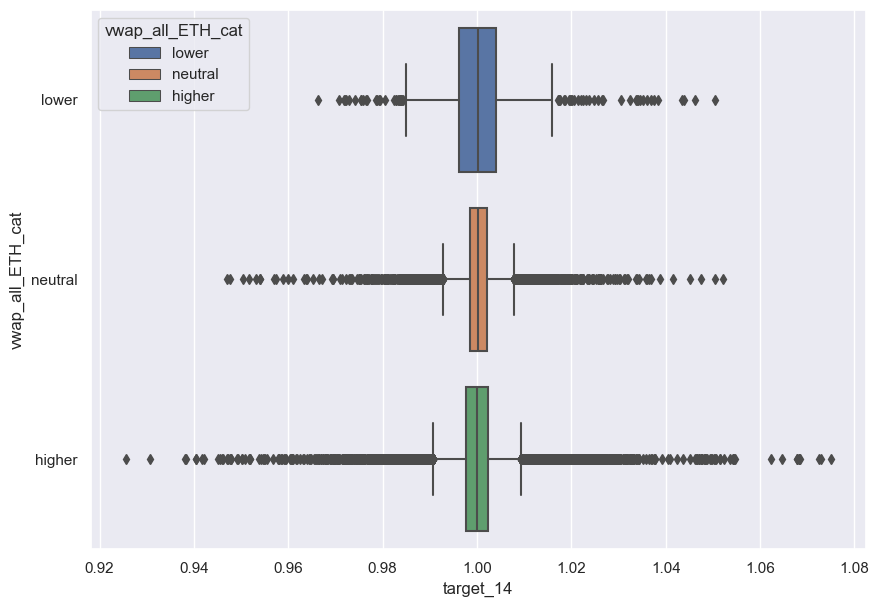

In [294]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

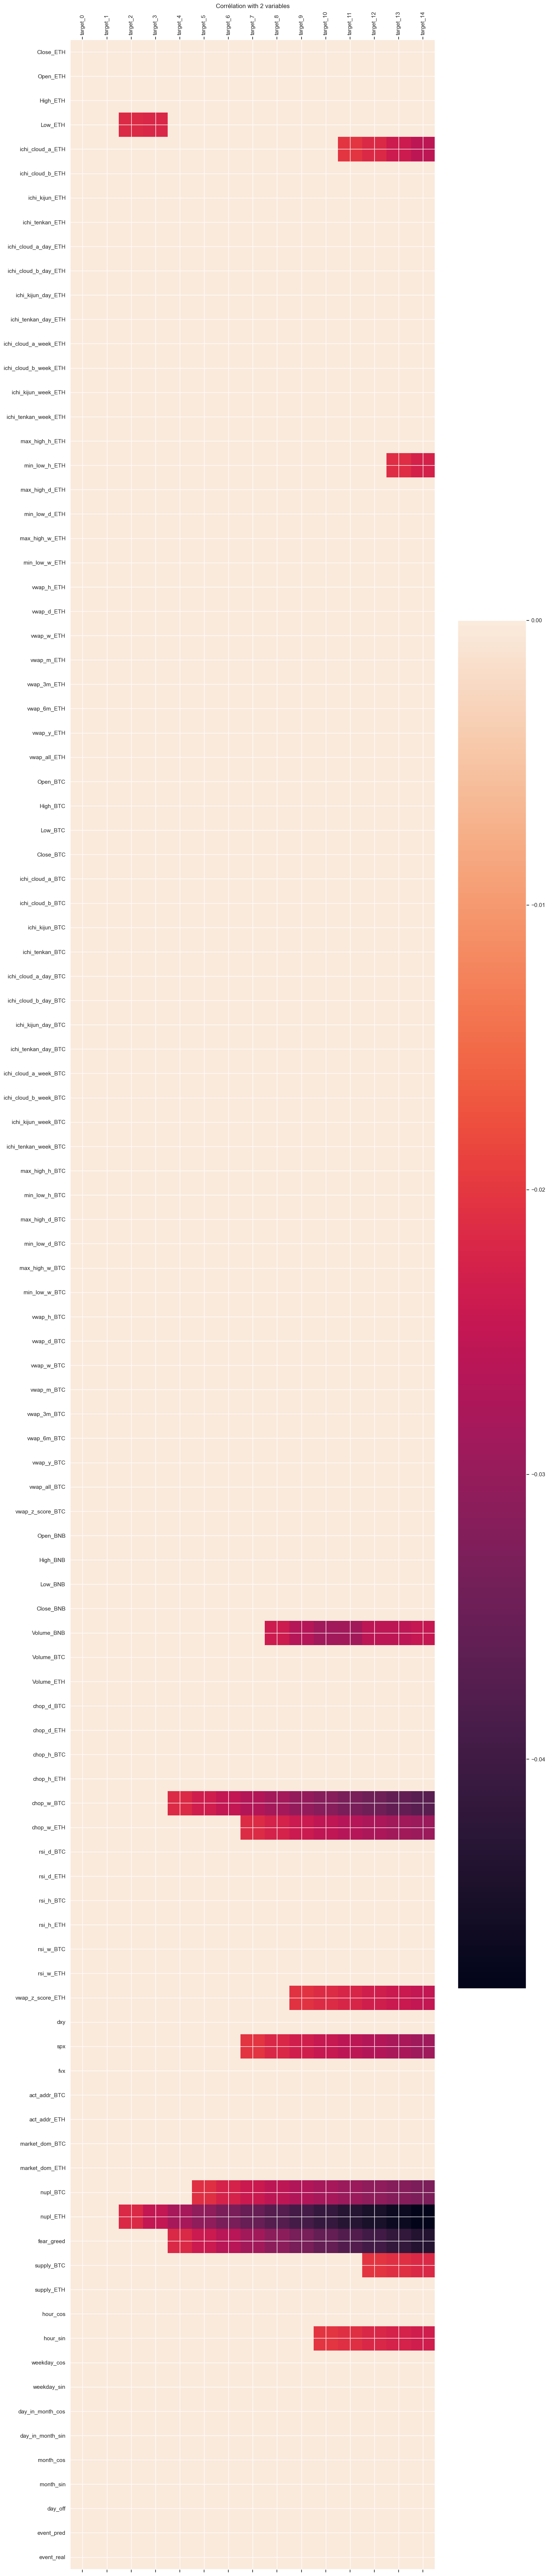

In [295]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

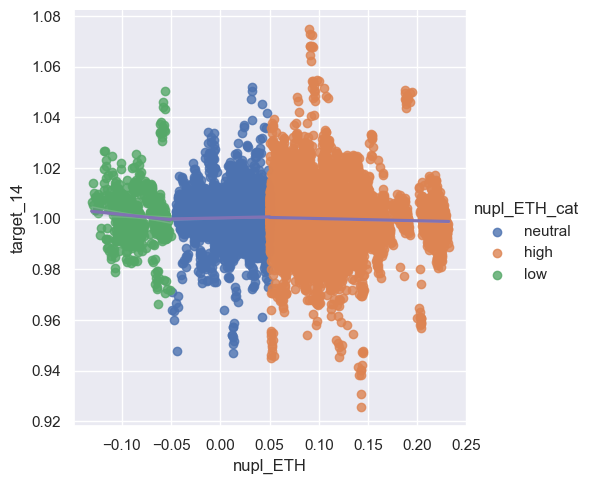

In [296]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

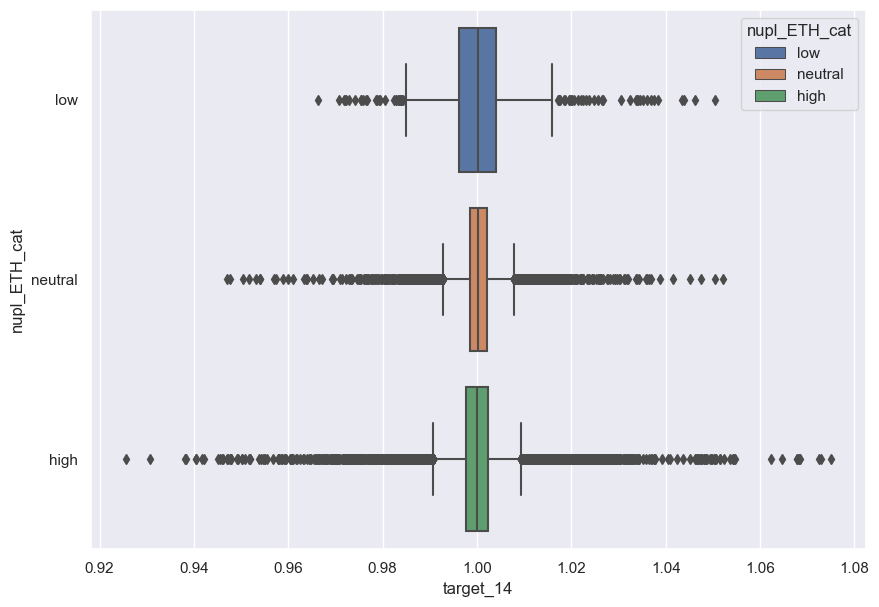

In [297]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [298]:
df["target_14"].describe()

count    50381.000000
mean         1.000158
std          0.006027
min          0.925613
25%          0.997886
50%          1.000045
75%          1.002315
max          1.074927
Name: target_14, dtype: float64

In [299]:
df["target_1"].describe()

count    50381.000000
mean         1.000021
std          0.002217
min          0.967271
25%          0.999169
50%          1.000011
75%          1.000857
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

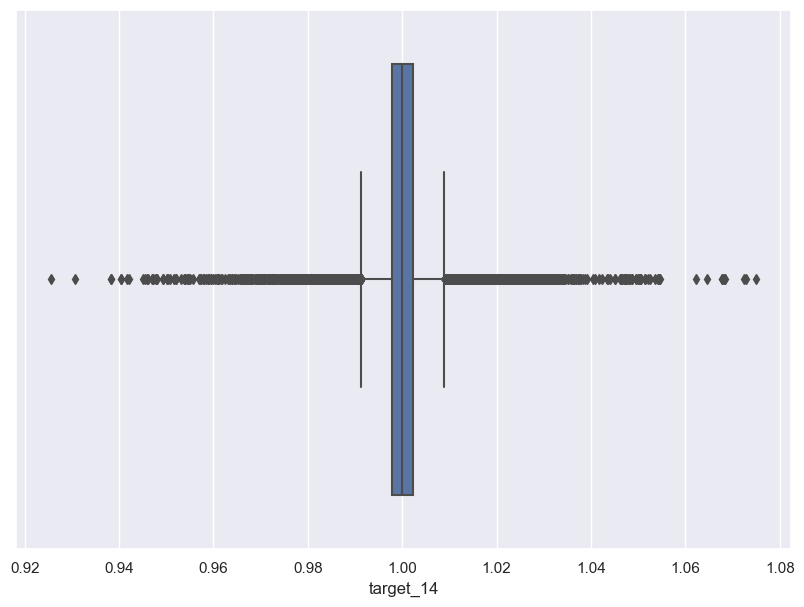

In [300]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [301]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00223869, 1.00441417, 1.00393483, ..., 1.0060629 , 1.00504101,
        1.00692678],
       [1.00217062, 1.00169235, 1.00458301, ..., 1.00279606, 1.00467761,
        1.0052137 ],
       [0.99952276, 1.00240716, 1.00274805, ..., 1.00250156, 1.00303649,
        1.00268511]])

In [302]:
y_train_sca

array([[ 0.08514324,  0.06809304, -0.10430349, ..., -0.04368054,
         0.01504795, -0.05125841],
       [-0.03609482, -0.20841201, -0.05692437, ..., -0.0891155 ,
        -0.15539134, -0.28983662],
       [-0.19138263, -0.03988358, -0.14782665, ..., -0.13835796,
        -0.27281337, -0.33720047],
       ...,
       [ 0.48756735,  0.97988261,  0.87140637, ...,  1.3529932 ,
         1.12173616,  1.54848885],
       [ 0.47216311,  0.36392917,  1.01809035, ...,  0.6136998 ,
         1.03949926,  1.16081643],
       [-0.12705198,  0.52569234,  0.60283485, ...,  0.54705488,
         0.66810928,  0.58859316]])

## Autoencoder

In [303]:
X_train.shape

(50381, 72, 104)

### Model creation

### Training

In [304]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 15 #100 #150 #6 #300
patience = 4 #20 #40 #3 #100
for n_unit_enc in [128]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.05]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            path_jpg = os.path.join(path_data, 
                f"output_MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}.jpg")
            if os.path.exists(path_jpg):
                print(f"BE CAREFUL ! : {path_jpg} exists => no training done...")
                continue
            print(f"Training: units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}",
                saveFolder="data")
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")


BE CAREFUL ! : data/output_MSE autoencoder - units 128 - enc_dim 32 - drop 0.05.jpg exists => no training done...


### Save model

In [305]:
# TODO select best model


In [306]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [307]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [308]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1575/1575 [==============================] - 39s 25ms/step


(50381, 72, 104)

### Results

In [309]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

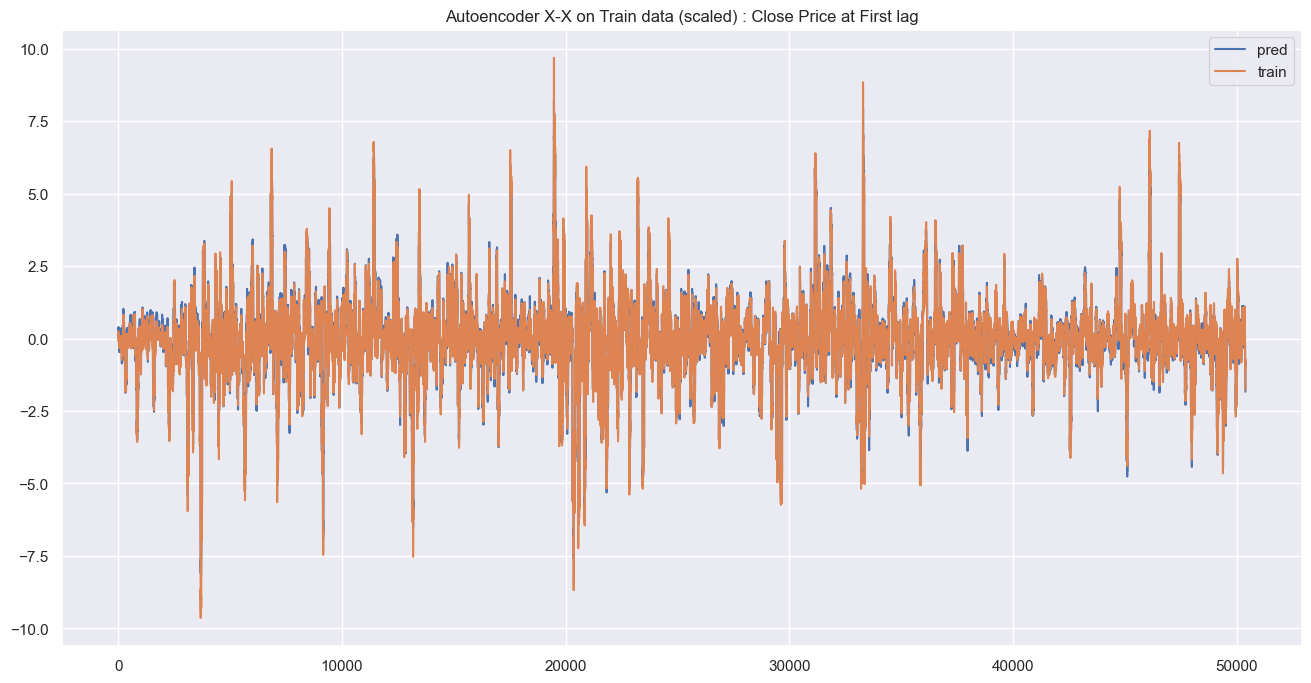

In [310]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [311]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(50381, 72, 104)
(50381, 72, 104)
(72, 104)
(1, 104)


In [312]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.109049  0.110146  0.092238  0.097916          0.144800   
lag_1    0.093837  0.090996  0.078113  0.083607          0.129228   
lag_2    0.085472  0.086501  0.070422  0.077782          0.115394   
lag_3    0.084204  0.085502  0.069613  0.076372          0.111102   
lag_4    0.081356  0.082767  0.066888  0.073645          0.106484   
...           ...       ...       ...       ...               ...   
lag_67   0.066045  0.072209  0.052808  0.060094          0.074128   
lag_68   0.065871  0.072104  0.052652  0.059941          0.074070   
lag_69   0.065669  0.072037  0.052489  0.059779          0.074039   
lag_70   0.065487  0.071915  0.052314  0.059655          0.074012   
lag_71   0.065224  0.071922  0.052059  0.059487          0.074012   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.133746        0.125992         0.112934   
lag_1           0.109200        0.114244         0.099842   
lag_2           0.096619        0.108134         0.092596   
lag_3           0.092668        0.104803         0.090062   
lag_4           0.089208        0.100532         0.085276   
...                  ...             ...              ...   
lag_67          0.078038        0.073112         0.064274   
lag_68          0.077962        0.073009         0.064192   
lag_69          0.077889        0.072873         0.064153   
lag_70          0.077824        0.072742         0.064138   
lag_71          0.077789        0.072625         0.064106   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
lag_0               0.130619              0.117741  ...  0.171929   
lag_1               0.102391              0.095509  ...  0.107470   
lag_2               0.088891              0.083699  ...  0.085266   
lag_3               0.083783              0.078346  ...  0.076126   
lag_4               0.079531              0.074163  ...  0.068479   
...                      ...                   ...  ...       ...   
lag_67              0.066923              0.061129  ...  0.051264   
lag_68              0.066930              0.061128  ...  0.051225   
lag_69              0.066928              0.061128  ...  0.051215   
lag_70              0.066922              0.061127  ...  0.051167   
lag_71              0.066936              0.061125  ...  0.051133   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.151736     0.154831          0.167104          0.152099   
lag_1      0.098895     0.099493          0.110990          0.102290   
lag_2      0.083283     0.077941          0.089148          0.084347   
lag_3      0.075089     0.069374          0.080413          0.076109   
lag_4      0.068280     0.063230          0.073441          0.068862   
...             ...          ...               ...               ...   
lag_67     0.048175     0.051361          0.051550          0.054964   
lag_68     0.048072     0.051340          0.051532          0.054947   
lag_69     0.047986     0.051317          0.051507          0.054919   
lag_70     0.047905     0.051282          0.051469          0.054882   
lag_71     0.047812     0.051252          0.051449          0.054857   

        month_cos  month_sin   day_off  event_pred  event_real  
lag_0    0.099376   0.155351  0.140492    0.289752    0.299064  
lag_1    0.070305   0.115094  0.110700    0.172044    0.187786  
lag_2    0.060626   0.093161  0.080342    0.113481    0.127999  
lag_3    0.056434   0.082762  0.061529    0.083890    0.100088  
lag_4    0.051815   0.074222  0.051212    0.072303    0.088024  
...           ...        ...       ...         ...         ...  
lag_67   0.041512   0.043678  0.032605    0.046696    0.054986  
lag_68   0.041492   0.043662  0.032587    0.046642    0.054893  
lag_69   0.041475   0.043642  0.032548    0.046611    0.054842  
lag_70   0.041451   0.043646  0.032548    0.046583    0.054815  
lag_71   0.041418   0.043649  0.03252

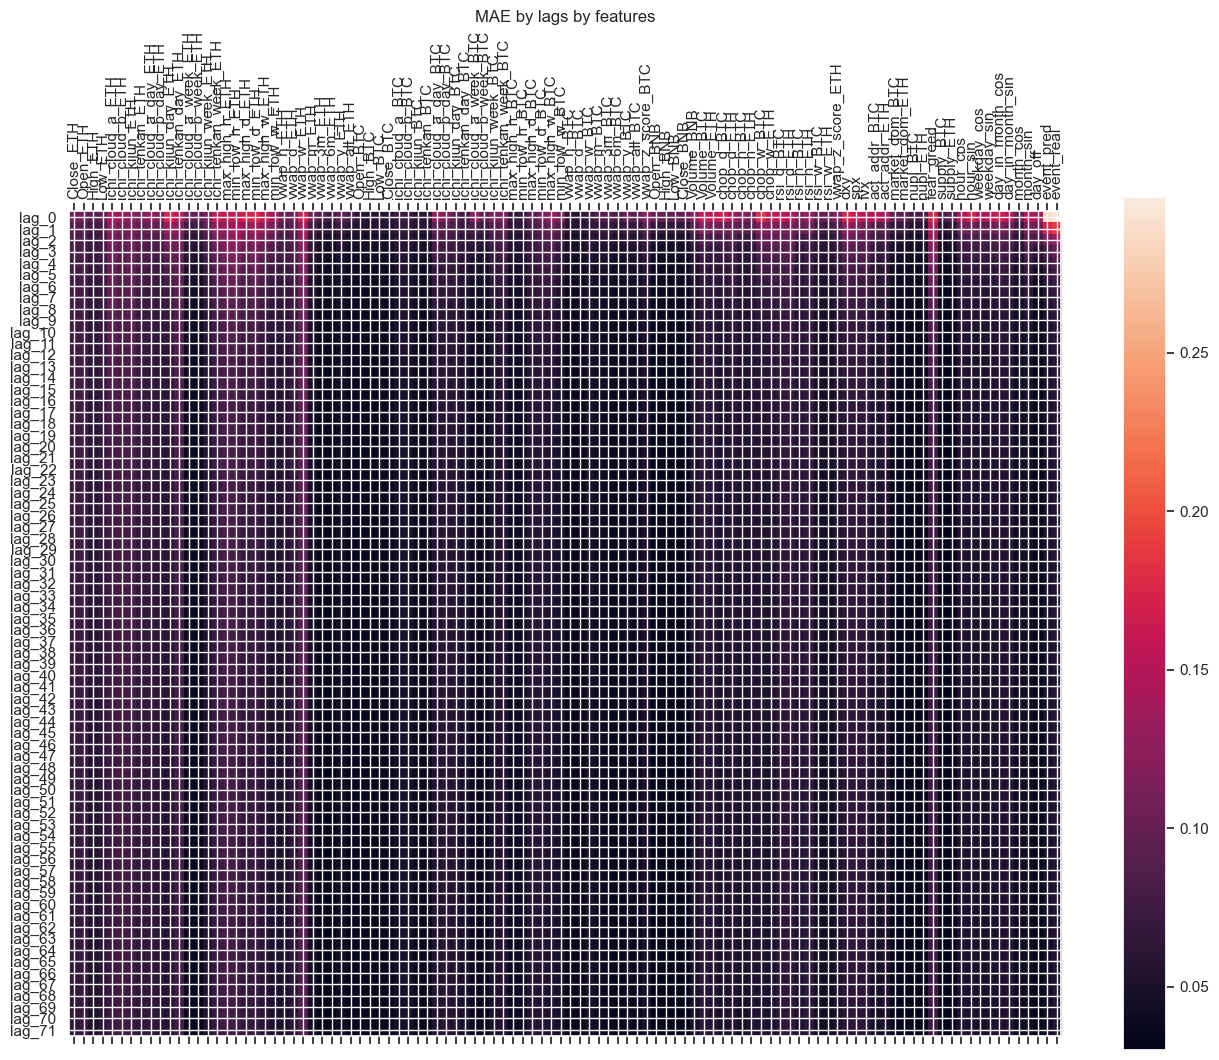

In [313]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

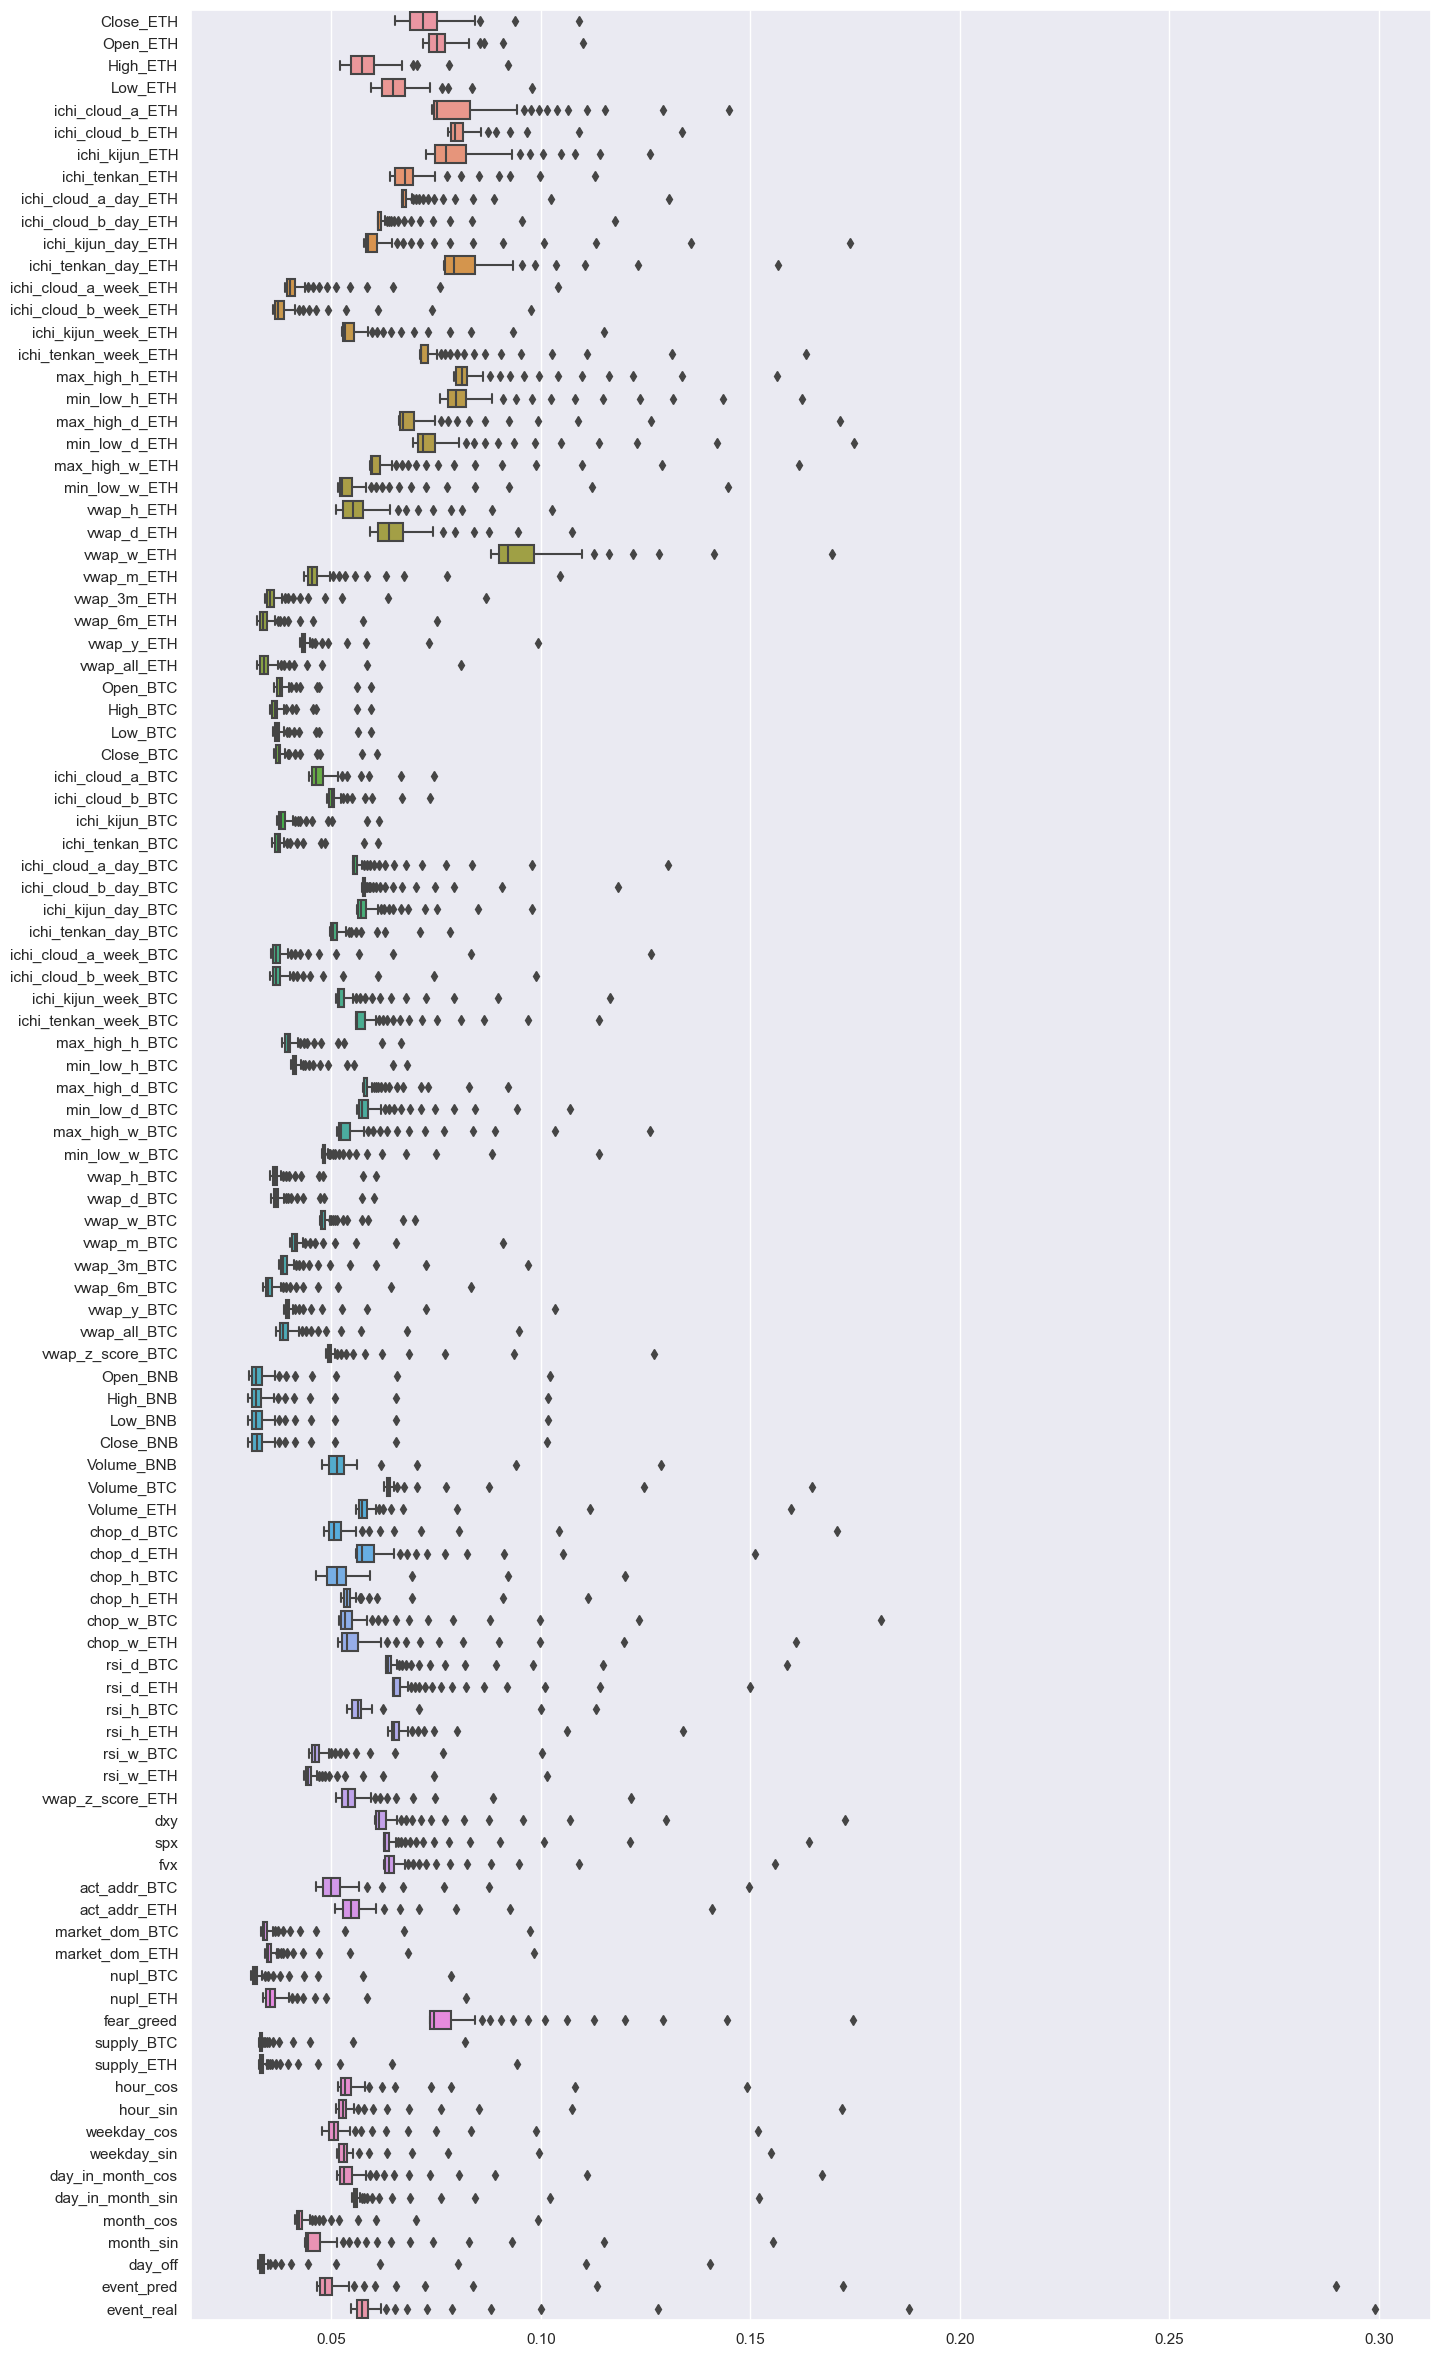

In [314]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [315]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.072864  0.076202  0.058424  0.065688          0.081846   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.081746        0.080786         0.069497              0.069771   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.063832  ...  0.056368     0.053915     0.055657   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin   day_off  \
0          0.057364          0.058792   0.044406   0.050434  0.037592   

   event_pred  event_real  
0    0.055917    0.065133  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

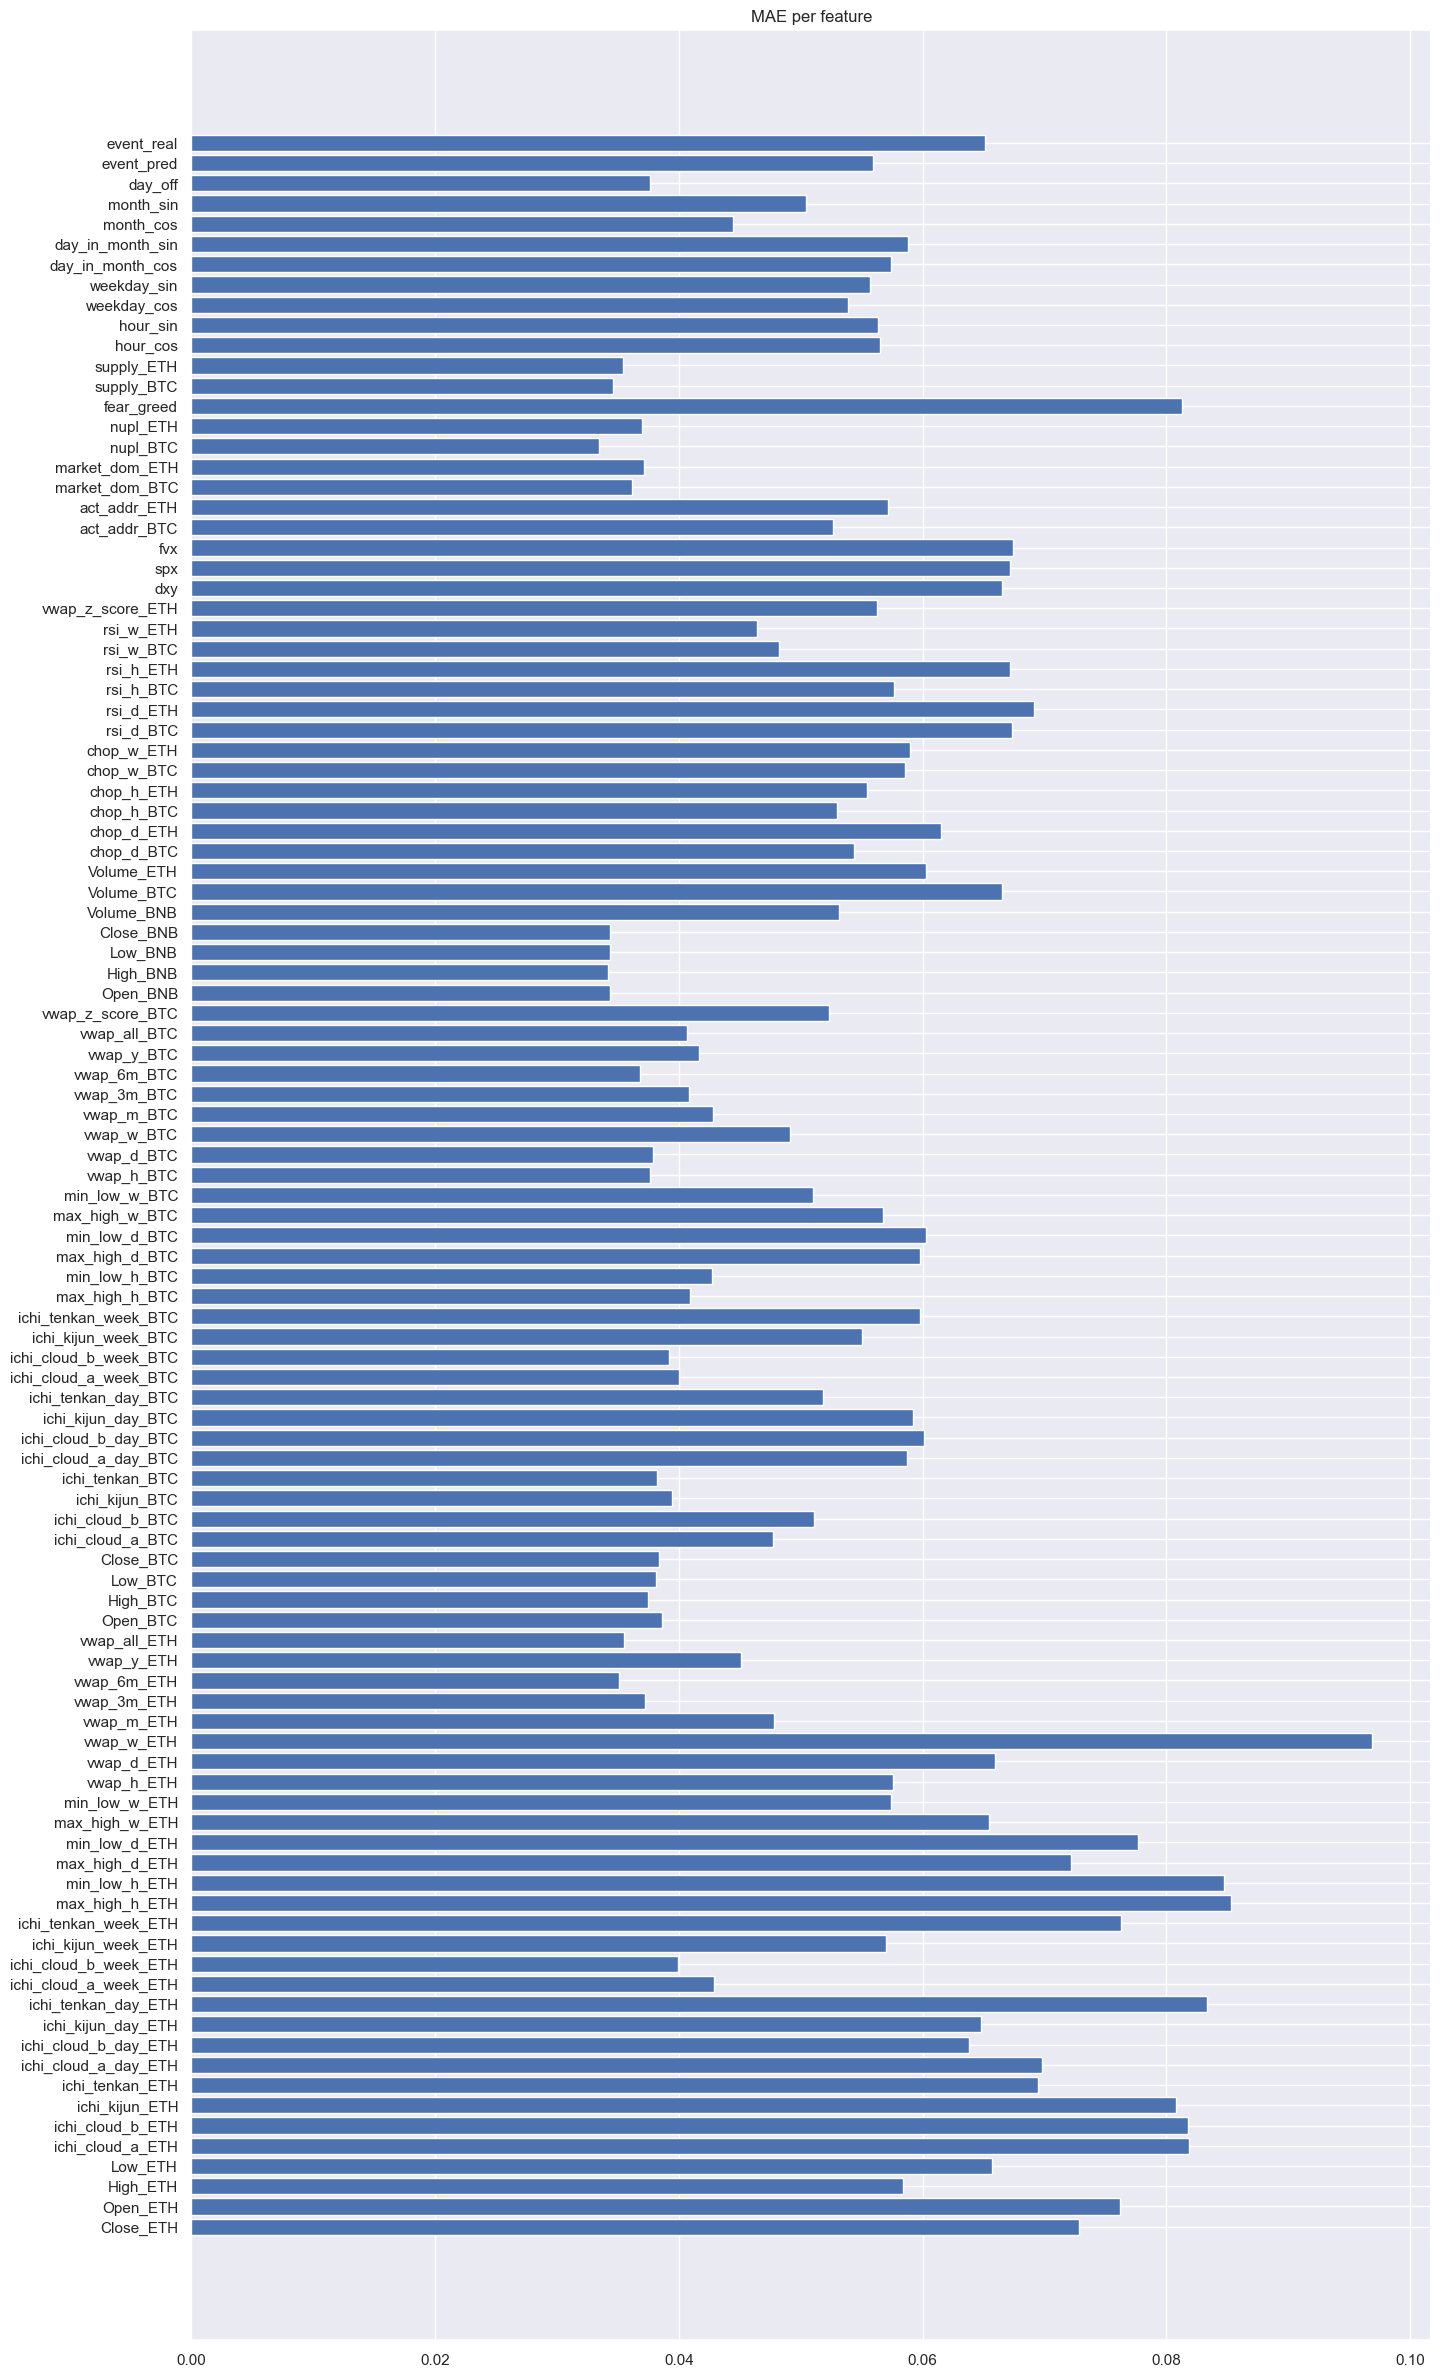

In [316]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [317]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(50381,)
(50381,)
[1196.32 1195.38 1194.55 ... 1875.54 1872.99 1874.77]
[1196.32 1195.38 1194.55]


In [318]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.0003557 , 1.0009186 , 1.0012085 , ..., 0.9999329 , 0.99901146,
       0.9991055 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1875.54 1872.99 1874.77]
[1198.1457171  1198.66033616 1198.65667999 ... 1874.51079153 1873.46663397
 1873.55951236]


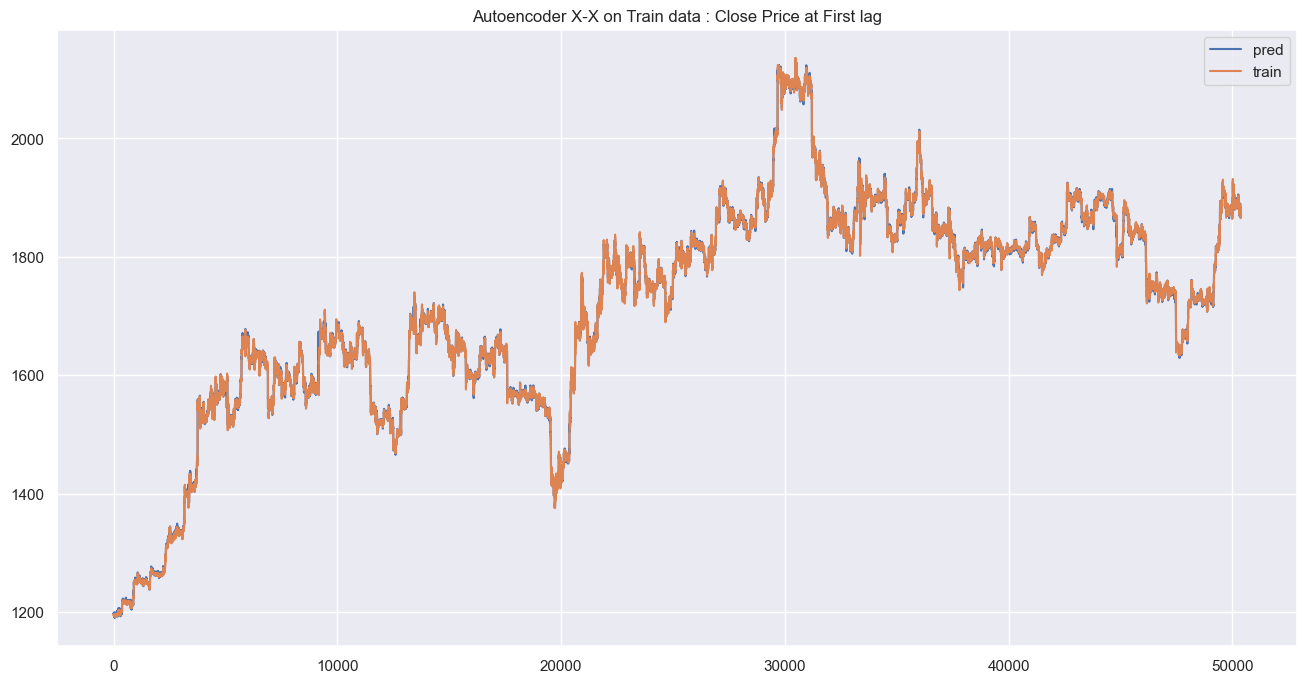

In [319]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [320]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

14/14 [==============================] - 0s 30ms/step


(422, 72, 104)

In [321]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-06-25 05:35:00'

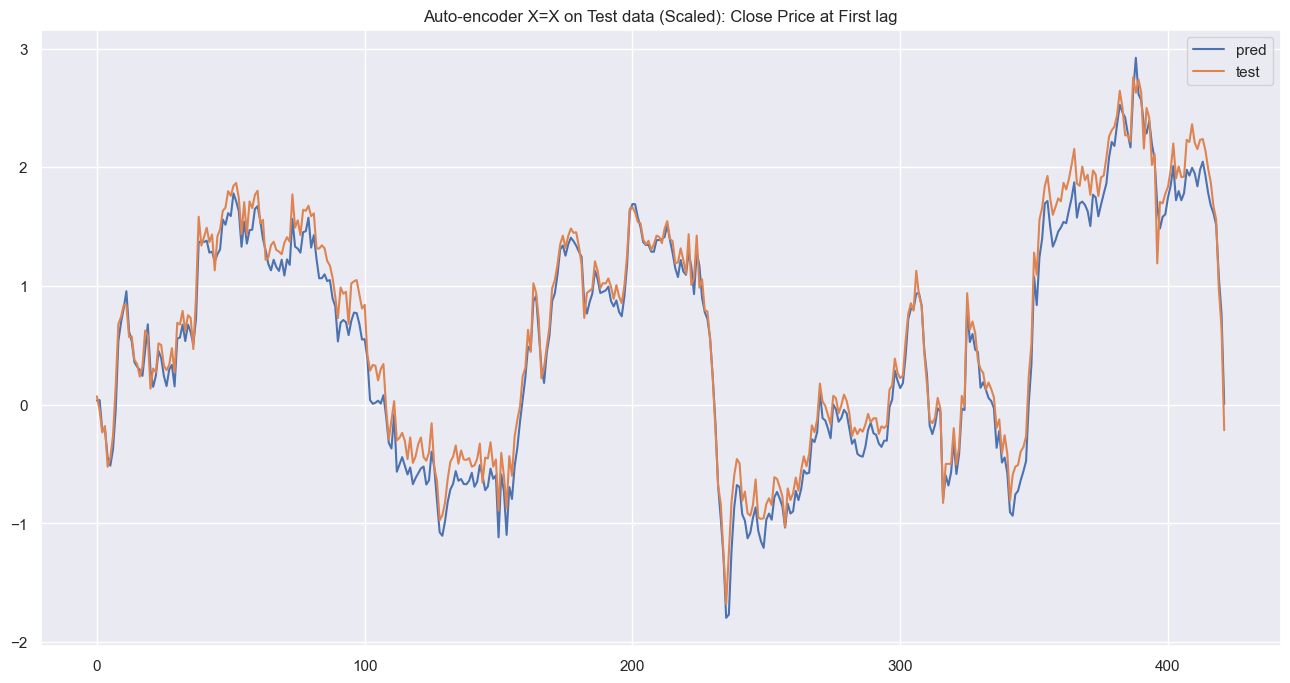

In [322]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [323]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1916.55 1914.45 1912.32 1911.73 1908.46 1909.39 1912.28 1918.5  1925.  ]
X test pred :  [1915.91665456 1915.97649073 1912.5776646  1911.21918872 1909.85584911
 1908.21965398 1910.25737793 1914.87613195 1922.4277407 ]


[1916.55 1914.45 1912.32 1911.73 1908.46 1909.39 1912.28 1918.5  1925.
 1927.27 1927.23 1924.04 1921.57 1921.55 1920.61 1920.07 1917.02 1918.52
 1919.58 1916.15 1909.99 1912.53 1910.01 1910.47 1911.82 1910.69 1911.78
 1911.81 1913.61 1913.29 1914.96 1914.52 1917.8  1916.7  1916.29 1916.92
 1912.2  1914.66 1920.7  1916.39 1914.67 1914.2  1913.21 1914.6  1909.23
 1911.1  1913.69 1914.96 1915.82 1919.46 1920.81 1918.19 1918.98 1918.1
 1916.63 1916.2  1913.33 1917.08 1917.44 1919.62 1922.41 1919.91 1920.53
 1915.13 1913.29 1916.07 1916.19 1915.37 1915.41 1911.69 1913.99 1915.81
 1915.81 1917.05 1915.47 1918.37 1917.97 1917.53 1916.28 1913.37 1914.54
 1912.74 1909.57 1911.89 1911.77 1914.36 1914.46 1913.32 1913.32 1908.94
 1906.29 1908.09 1907.61 1905.69 1901.79 1903.38 1905.34 1907.11 1906.33
 1905.64 1909.   1903.19 1903.   1904.24 1906.17 1903.38 1904.4  1904.37
 1899.14 1893.16 1893.16 1890.21 1888.37 1889.5  1889.76 1889.73 1886.54
 1888.13 1886.65 1887.03 1888.18 1890.2  1886.16 1886.

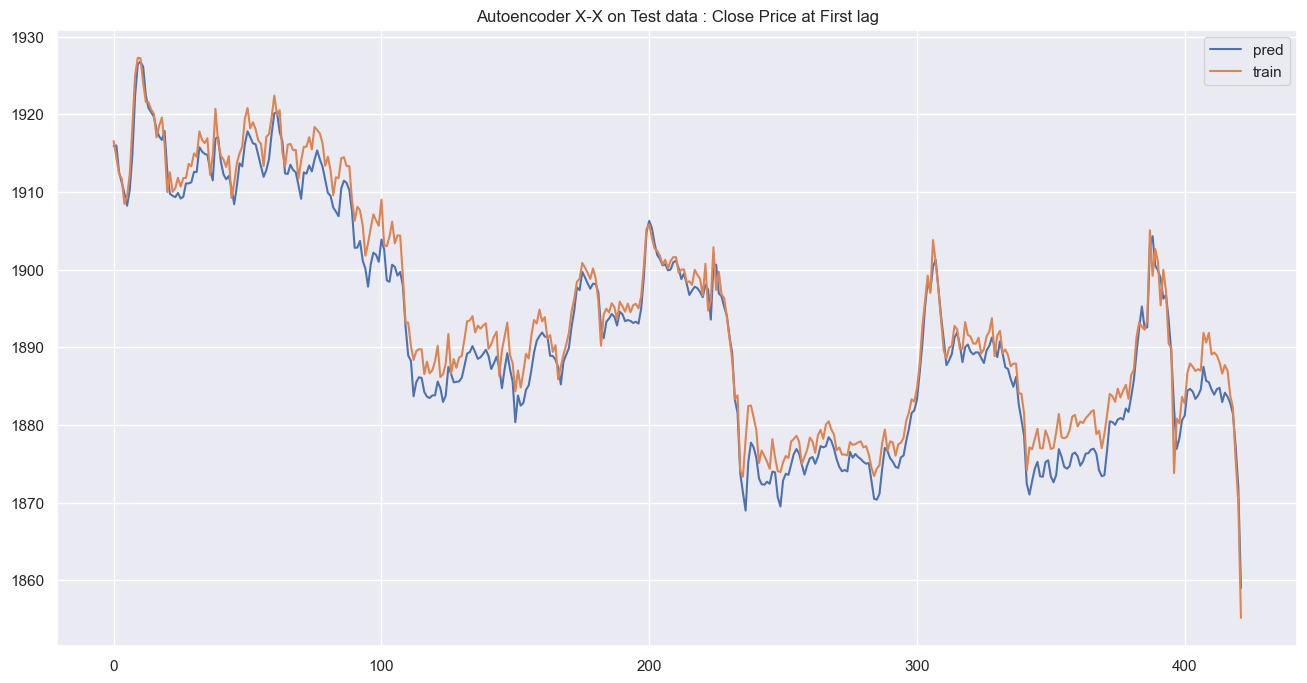

In [324]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [325]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(422, 72, 104)
(422, 72, 104)
(72, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.109049  0.110146  0.092238  0.097916          0.144800   
lag_1    0.093837  0.090996  0.078113  0.083607          0.129228   
lag_2    0.085472  0.086501  0.070422  0.077782          0.115394   
lag_3    0.084204  0.085502  0.069613  0.076372          0.111102   
lag_4    0.081356  0.082767  0.066888  0.073645          0.106484   
...           ...       ...       ...       ...               ...   
lag_67   0.091358  0.104086  0.080640  0.088881          0.104745   
lag_68   0.090982  0.103378  0.079812  0.088605          0.103961   
lag_69   0.089864  0.102450  0.078843  0.087427          0.103280   
lag_70   0.089656  0.101535  0.078158  0.087378          0.102783   
lag_71   0.088008  0.101512  0.077126  0.086814          0.102436   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.133746        0.125992         0.112934   
lag_1           0.109200        0.114244         0.099842   
lag_2           0.096619        0.108134         0.092596   
lag_3           0.092668        0.104803         0.090062   
lag_4           0.089208        0.100532         0.085276   
...                  ...             ...              ...   
lag_67          0.147905        0.102553         0.075740   
lag_68          0.147491        0.102020         0.075185   
lag_69          0.147105        0.101501         0.074646   
lag_70          0.146631        0.101343         0.073959   
lag_71          0.146321        0.100950         0.073514   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.130619              0.117741  ...     0.151736   
lag_1               0.102391              0.095509  ...     0.098895   
lag_2               0.088891              0.083699  ...     0.083283   
lag_3               0.083783              0.078346  ...     0.075089   
lag_4               0.079531              0.074163  ...     0.068280   
...                      ...                   ...  ...          ...   
lag_67              0.070345              0.113341  ...     0.092084   
lag_68              0.070290              0.113514  ...     0.091938   
lag_69              0.070169              0.113643  ...     0.091747   
lag_70              0.070106              0.113754  ...     0.091643   
lag_71              0.070058              0.113863  ...     0.091371   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.154831          0.167104          0.152099   0.099376   0.155351   
lag_1      0.099493          0.110990          0.102290   0.070305   0.115094   
lag_2      0.077941          0.089148          0.084347   0.060626   0.093161   
lag_3      0.069374          0.080413          0.076109   0.056434   0.082762   
lag_4      0.063230          0.073441          0.068862   0.051815   0.074222   
...             ...               ...               ...        ...        ...   
lag_67     0.047390          0.227379          0.157761   0.050925   0.048753   
lag_68     0.047521          0.228041          0.157880   0.050761   0.048557   
lag_69     0.047526          0.228682          0.158065   0.050693   0.048467   
lag_70     0.047419          0.229333          0.158173   0.050552   0.048301   
lag_71     0.047452          0.230061          0.158316   0.050374   0.048271   

         day_off  event_pred  event_real  dataset  
lag_0   0.140492    0.289752    0.299064    TRAIN  
lag_1   0.110700    0.172044    0.187786    TRAIN  
lag_2   0.080342    0.113481    0.127999    TRAIN  
lag_3   0.061529    0.083890    0.100088    TRAIN  
lag_4   0.051212    0.072303    0.088024    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.041808    0.185072    0.048146     TEST  
lag_68  0.041894    0.185368    0.048183     TEST  
lag_69  0.041969    0.185515    0.047992     TEST  
lag_70  0.042018    0.185929    0.048231     TEST  
lag_71  0.041792    0.186101    0.04

In [326]:
df_mae_ae_comp

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.109049  0.110146  0.092238  0.097916          0.144800   
lag_1    0.093837  0.090996  0.078113  0.083607          0.129228   
lag_2    0.085472  0.086501  0.070422  0.077782          0.115394   
lag_3    0.084204  0.085502  0.069613  0.076372          0.111102   
lag_4    0.081356  0.082767  0.066888  0.073645          0.106484   
...           ...       ...       ...       ...               ...   
lag_67   0.091358  0.104086  0.080640  0.088881          0.104745   
lag_68   0.090982  0.103378  0.079812  0.088605          0.103961   
lag_69   0.089864  0.102450  0.078843  0.087427          0.103280   
lag_70   0.089656  0.101535  0.078158  0.087378          0.102783   
lag_71   0.088008  0.101512  0.077126  0.086814          0.102436   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.133746        0.125992         0.112934   
lag_1           0.109200        0.114244         0.099842   
lag_2           0.096619        0.108134         0.092596   
lag_3           0.092668        0.104803         0.090062   
lag_4           0.089208        0.100532         0.085276   
...                  ...             ...              ...   
lag_67          0.147905        0.102553         0.075740   
lag_68          0.147491        0.102020         0.075185   
lag_69          0.147105        0.101501         0.074646   
lag_70          0.146631        0.101343         0.073959   
lag_71          0.146321        0.100950         0.073514   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.130619              0.117741  ...     0.151736   
lag_1               0.102391              0.095509  ...     0.098895   
lag_2               0.088891              0.083699  ...     0.083283   
lag_3               0.083783              0.078346  ...     0.075089   
lag_4               0.079531              0.074163  ...     0.068280   
...                      ...                   ...  ...          ...   
lag_67              0.070345              0.113341  ...     0.092084   
lag_68              0.070290              0.113514  ...     0.091938   
lag_69              0.070169              0.113643  ...     0.091747   
lag_70              0.070106              0.113754  ...     0.091643   
lag_71              0.070058              0.113863  ...     0.091371   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.154831          0.167104          0.152099   0.099376   0.155351   
lag_1      0.099493          0.110990          0.102290   0.070305   0.115094   
lag_2      0.077941          0.089148          0.084347   0.060626   0.093161   
lag_3      0.069374          0.080413          0.076109   0.056434   0.082762   
lag_4      0.063230          0.073441          0.068862   0.051815   0.074222   
...             ...               ...               ...        ...        ...   
lag_67     0.047390          0.227379          0.157761   0.050925   0.048753   
lag_68     0.047521          0.228041          0.157880   0.050761   0.048557   
lag_69     0.047526          0.228682          0.158065   0.050693   0.048467   
lag_70     0.047419          0.229333          0.158173   0.050552   0.048301   
lag_71     0.047452          0.230061          0.158316   0.050374   0.048271   

         day_off  event_pred  event_real  dataset  
lag_0   0.140492    0.289752    0.299064    TRAIN  
lag_1   0.110700    0.172044    0.187786    TRAIN  
lag_2   0.080342    0.113481    0.127999    TRAIN  
lag_3   0.061529    0.083890    0.100088    TRAIN  
lag_4   0.051212    0.072303    0.088024    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.041808    0.185072    0.048146     TEST  
lag_68  0.041894    0.185368    0.048183     TEST  
lag_69  0.041969    0.185515    0.047992     TEST  
lag_70  0.042018    0.185929    0.048231     TEST  
lag_71  0.041792    0.186101    0.04

In [327]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.109049
1       TRAIN   Close_ETH  0.093837
2       TRAIN   Close_ETH  0.085472
3       TRAIN   Close_ETH  0.084204
4       TRAIN   Close_ETH  0.081356
...       ...         ...       ...
14971    TEST  event_real  0.048146
14972    TEST  event_real  0.048183
14973    TEST  event_real  0.047992
14974    TEST  event_real  0.048231
14975    TEST  event_real  0.048238

[14976 rows x 3 columns]

<AxesSubplot: xlabel='MAE', ylabel='variable'>

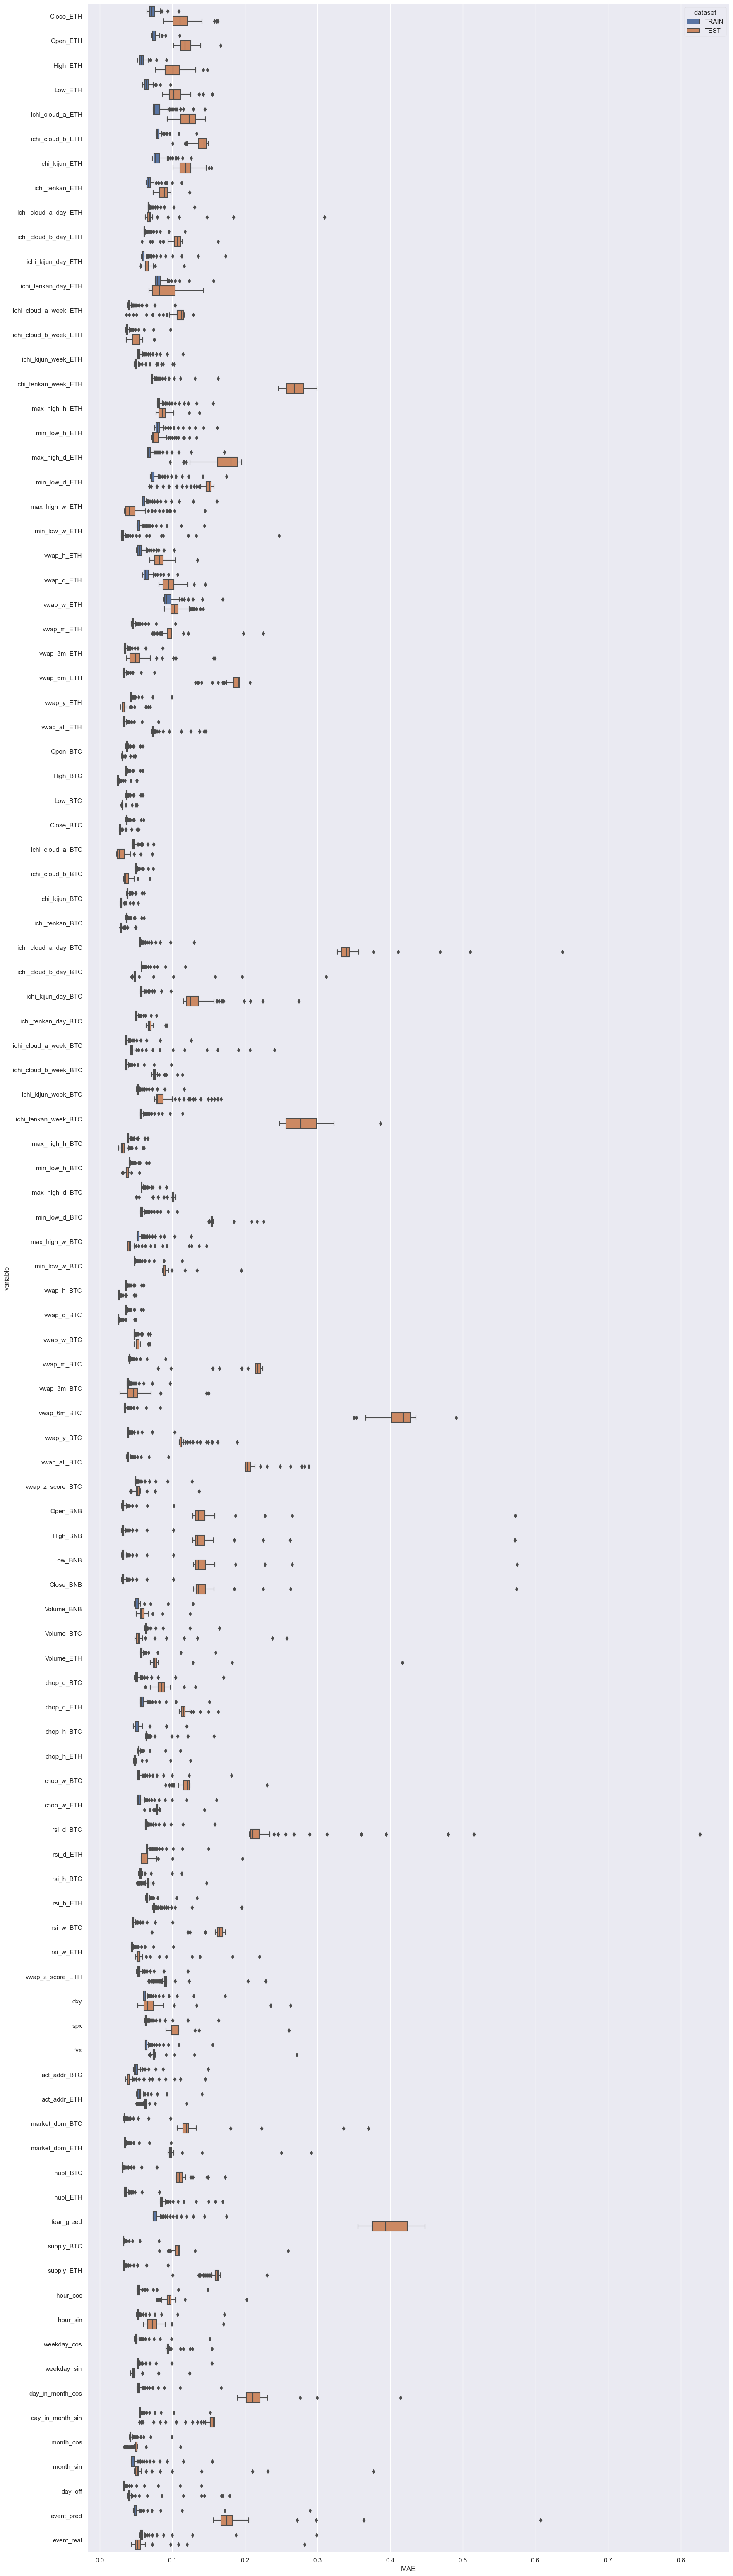

In [328]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")

In [329]:
encoder_model.layers[3].get_weights()

[array([[ 0.07956226, -0.39465415, -0.45812365, ..., -0.04169406,
          0.49886245, -0.32903978],
        [-0.02242858,  0.05549876, -0.11627809, ...,  0.16108823,
          0.01089997, -0.03305315],
        [ 0.12716886,  0.1703442 , -0.04800383, ..., -0.06978815,
         -0.24017806,  0.2543871 ],
        ...,
        [ 0.03235055, -0.21258321,  0.3956439 , ..., -0.485184  ,
         -0.13258433,  0.17625956],
        [-0.5409401 ,  0.1387113 ,  0.24126078, ..., -0.37925276,
         -0.3990218 ,  0.02311731],
        [ 0.16050243, -0.08281284, -0.14165935, ...,  0.14661652,
          0.19654875, -0.14534873]], dtype=float32),
 array([ 0.07130665, -0.06906886,  0.06081213, -0.01625548,  0.07635461,
         0.06129858,  0.07519083, -0.19363602,  0.06437602,  0.02985474,
        -0.15451363,  0.00429432, -0.24884824,  0.01530783, -0.13819772,
         0.06192659,  0.0133226 , -0.16634306,  0.03305987,  0.12882262,
         0.26188684,  0.00338213,  0.08642827,  0.04615805,  0.023

## Prediction Models

### LSTM all features

In [330]:
X_train_sca.shape

(50381, 72, 104)

In [331]:
X_train_sca.shape[-1]

104

In [332]:
X_train_sca.shape[-2:]

(72, 104)

In [333]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 50
patience = 20
dropout_rate = 0.4
n_units = 64
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
#multi_step_model_1.add(tf.keras.layers.LSTM(n_units[0], 
#                    return_sequences=True,
#                    input_shape=X_train_sca.shape[-2:],
#                    dropout=dropout_rate))
multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:],
                    dropout=dropout_rate))
#multi_step_model_1.add(tf.keras.layers.Dropout(dropout_rate))
multi_step_model_1.add(tf.keras.layers.LayerNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Epoch 1/50
1575/1575 [==============================] - 50s 30ms/step - loss: 1.0264 - val_loss: 0.9018
Epoch 2/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.9402 - val_loss: 0.8804
Epoch 3/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.8753 - val_loss: 1.0339
Epoch 4/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.8046 - val_loss: 1.0317
Epoch 5/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.7644 - val_loss: 0.9589
Epoch 6/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.7167 - val_loss: 1.0043
Epoch 7/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.6727 - val_loss: 0.8909
Epoch 8/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.6401 - val_loss: 1.1268
Epoch 9/50
1575/1575 [==============================] - 46s 29ms/step - loss: 0.6155 - val_loss: 1.1660
Epoch 10/50
1575/1575 [==============================] - 46s 29m

0.8803615570068359

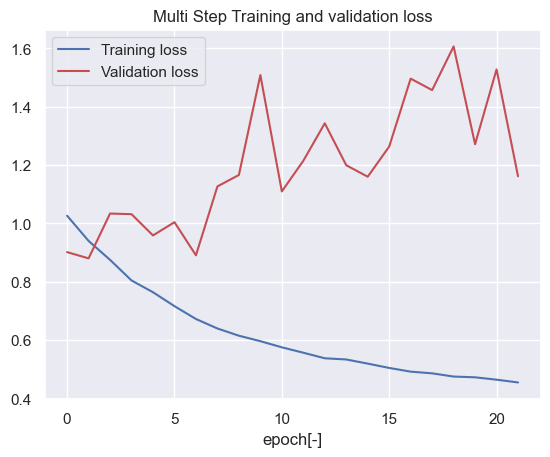

In [334]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss', "data")

#### Save

In [335]:
multi_step_model_1.save(path_mdl_predict_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


#### Results

In [336]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

14/14 [==============================] - 0s 17ms/step


In [337]:
y_train_pred_raw_1.shape

(50381, 15)

In [338]:
y_train_raw.shape

(50381, 15)

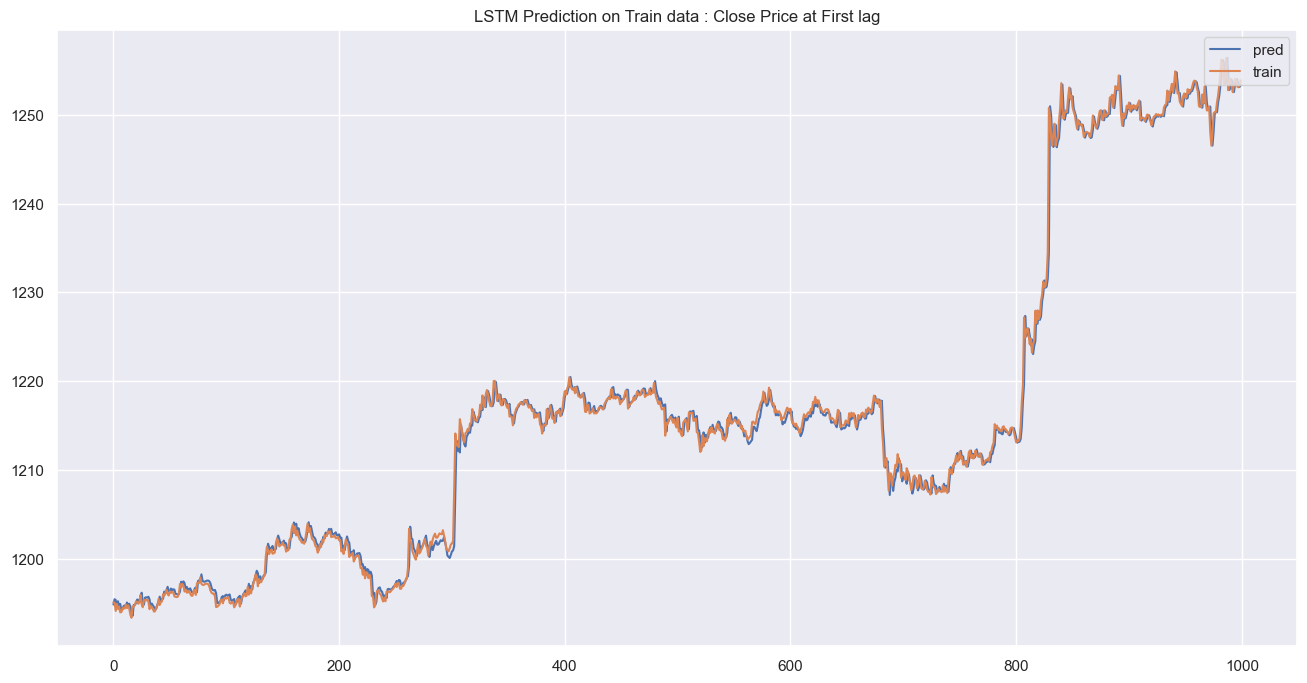

In [339]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

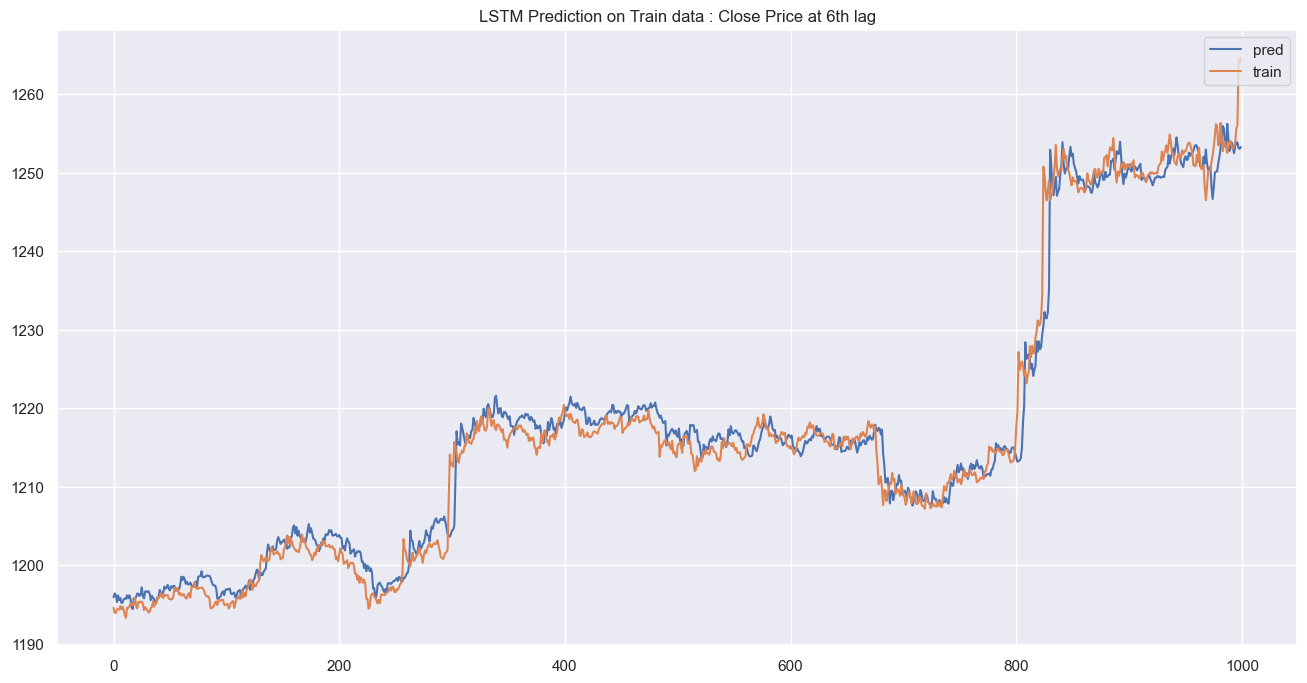

In [340]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

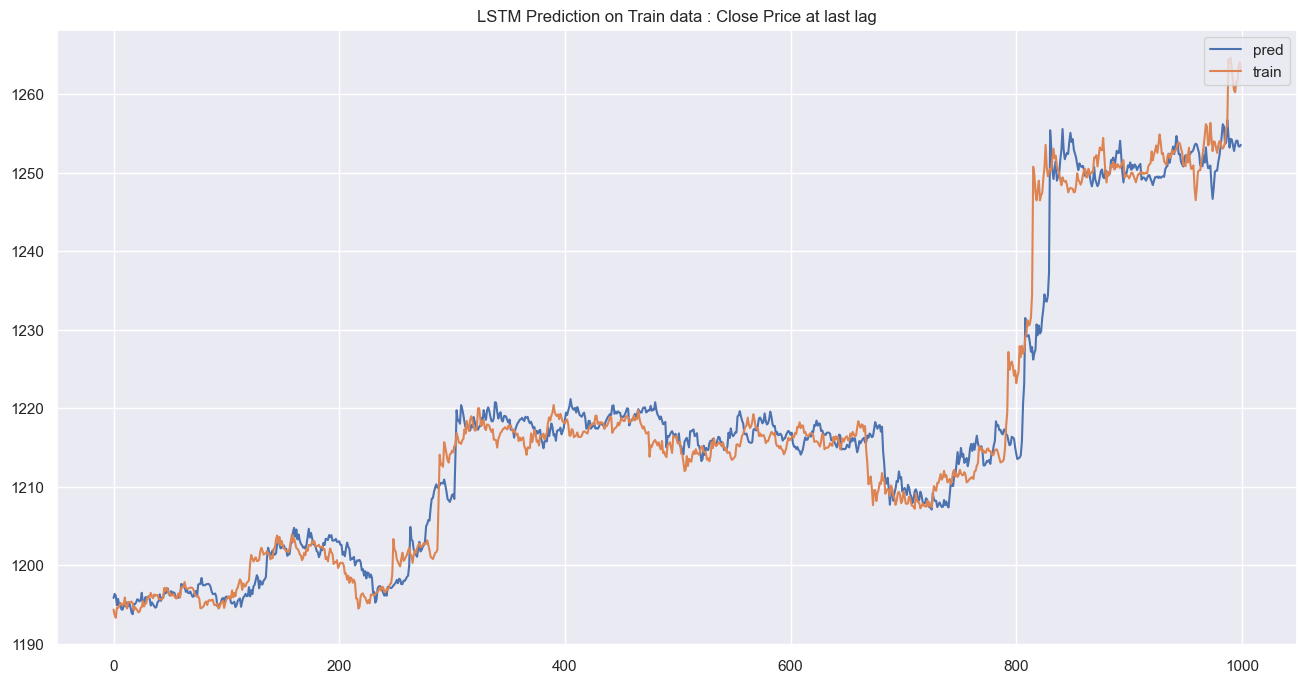

In [341]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

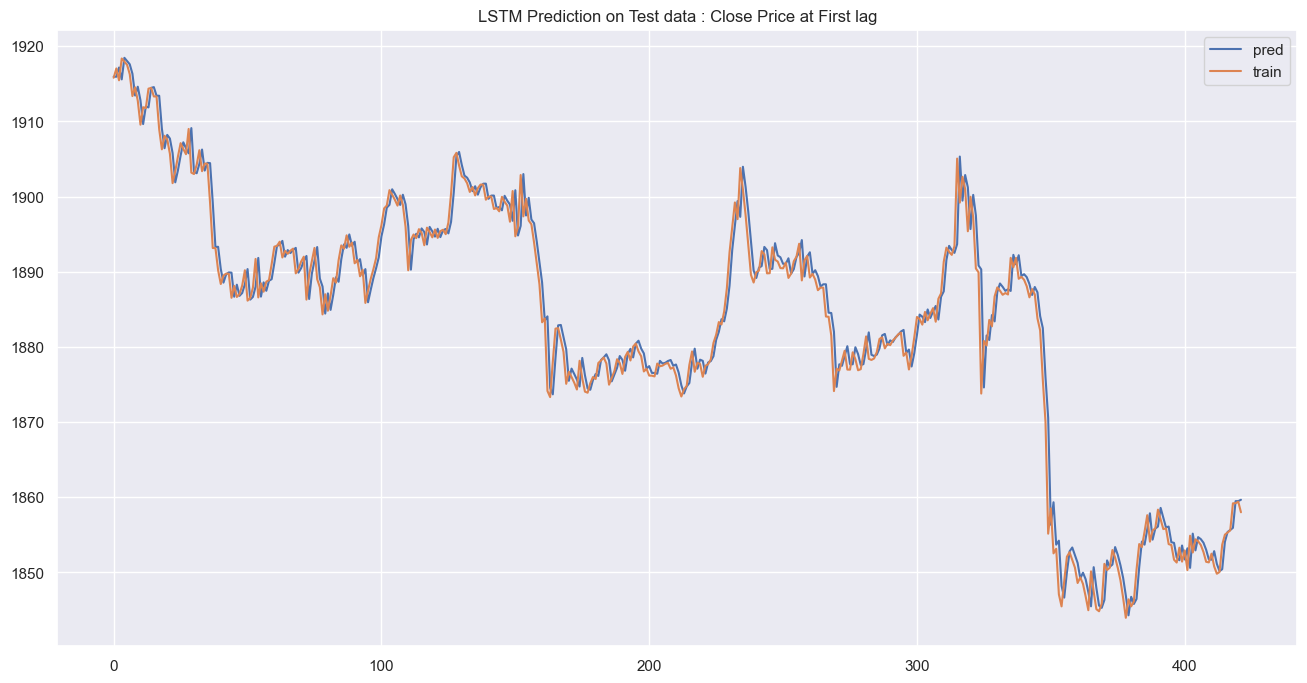

In [342]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

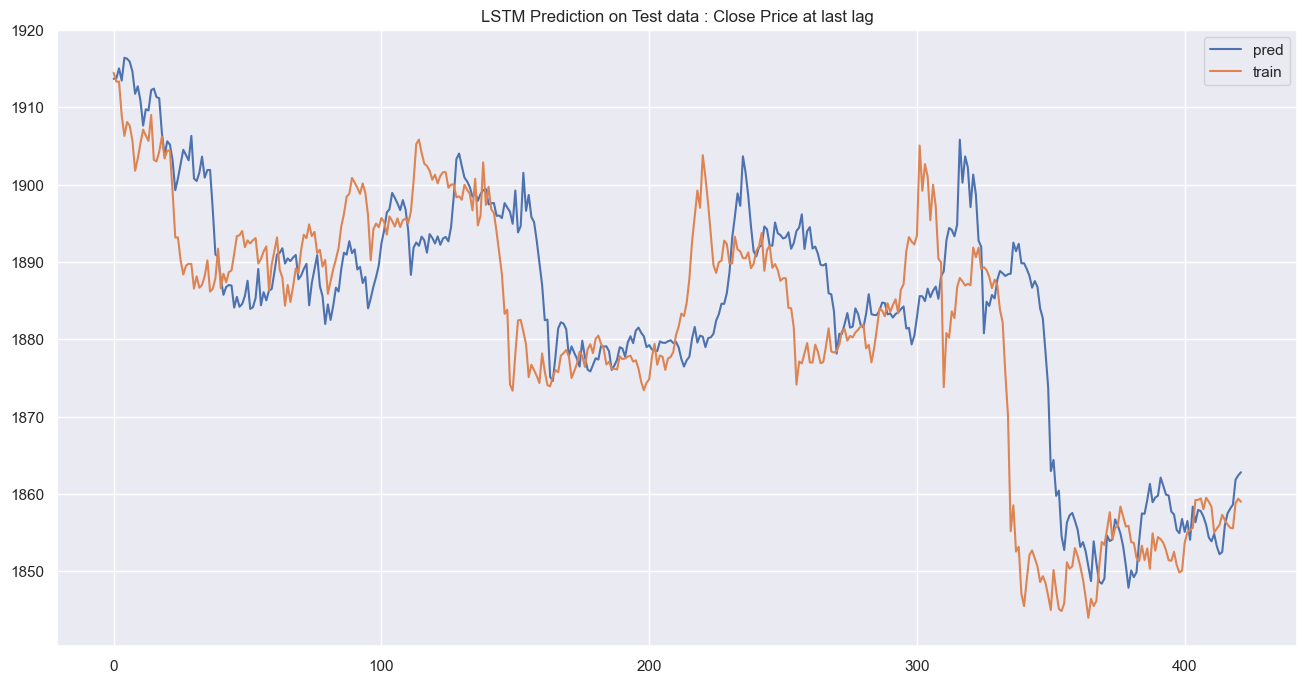

In [343]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [344]:
y_train_pred_unscaled_1[0,:]

array([1.000231 , 0.9997557, 1.0003148, 1.000751 , 1.0000546, 1.0011674,
       1.001293 , 1.0005074, 1.0007665, 1.0005164, 1.0005848, 1.0013318,
       1.0023638, 1.0009027, 1.0010955], dtype=float32)

In [348]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([1194.816 , 1194.2482, 1194.9161, 1195.4371, 1194.6052, 1195.9346,
       1196.0845, 1195.1461, 1195.4557, 1195.1569, 1195.2386, 1196.131 ,
       1197.3636, 1195.6183, 1195.8488], dtype=float32)

In [347]:
y_train_pred_raw_1[0,:]

array([1194.81597171, 1194.24815066, 1194.9160791 , 1195.43712167,
       1194.60521932, 1195.93452579, 1196.08447327, 1195.14605553,
       1195.4556337 , 1195.15687795, 1195.2386157 , 1196.13089576,
       1197.36365485, 1195.6182548 , 1195.84865843])

### Autoencoder + LSTM reduced features

In [349]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

In [350]:
X_train[:,:,0:4].shape

(50381, 72, 4)

In [351]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [352]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1575/1575 [==============================] - 20s 12ms/step


(50381, 72, 32)

In [353]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

12/14 [========================>.....] - ETA: 0s

14/14 [==============================] - 0s 20ms/step


(422, 72, 32)

In [354]:
# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)

In [355]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((50381, 72, 36), (422, 72, 36))

Train

In [366]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 200
patience = 100
dropout_rate = 0.5
n_units = 64
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(
    n_units,
    return_sequences=False,
    input_shape=X_train_.shape[-2:],
    )
)
multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.LayerNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_, y_test_sca), 
    verbose=1, 
    callbacks=[es]
)
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/200
1575/1575 [==============================] - 48s 29ms/step - loss: 1.0841 - val_loss: 0.9813
Epoch 2/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.8883 - val_loss: 0.9467
Epoch 3/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.7889 - val_loss: 1.1373
Epoch 4/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.6902 - val_loss: 1.5093
Epoch 5/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.6074 - val_loss: 1.2866
Epoch 6/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.5570 - val_loss: 1.1784
Epoch 7/200
1575/1575 [==============================] - 46s 29ms/step - loss: 0.5212 - val_loss: 0.9230
Epoch 8/200
1575/1575 [==============================] - 45s 29ms/step - loss: 0.4856 - val_loss: 1.0557
Epoch 9/200
1575/1575 [==============================] - 46s 29ms/step - loss: 0.4563 - val_loss: 0.9248
Epoch 10/200
1575/1575 [==============================]

0.827832818031311

### Results

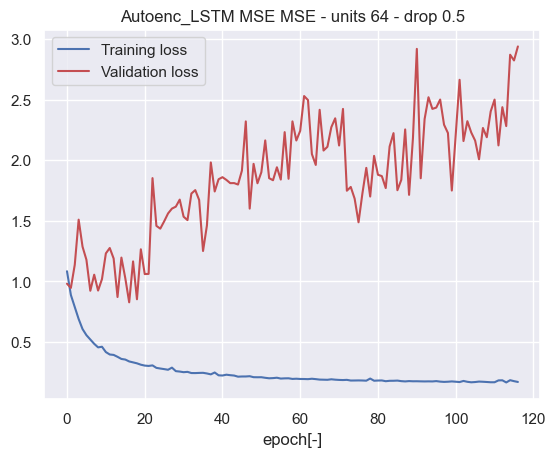

In [367]:
plot_train_history(
    multi_step_history,
    f"Autoenc_LSTM MSE MSE - units {n_units} - drop {dropout_rate}",
    saveFolder="data",
)

Save mdl

In [368]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Predict

In [369]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

14/14 [==============================] - 0s 19ms/step


Plots

In [389]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(50385,)
(50385,)


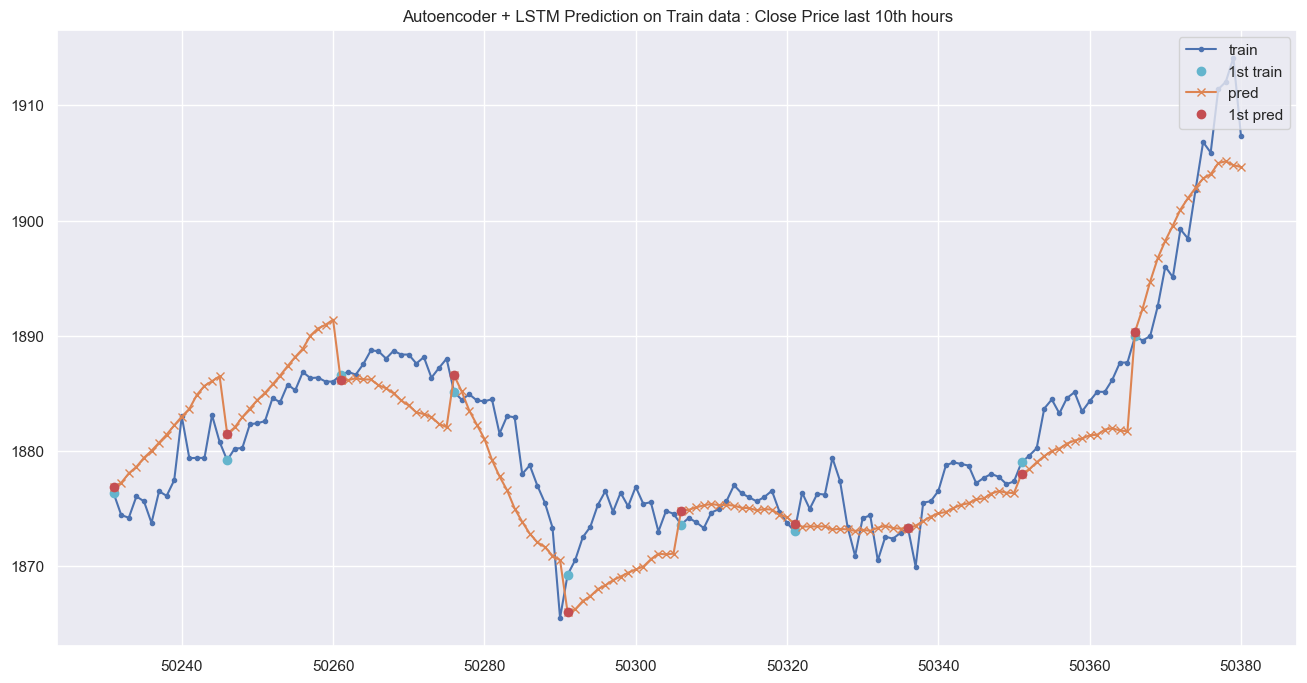

In [410]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price last 10th hours")
nb_pred = 10
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')

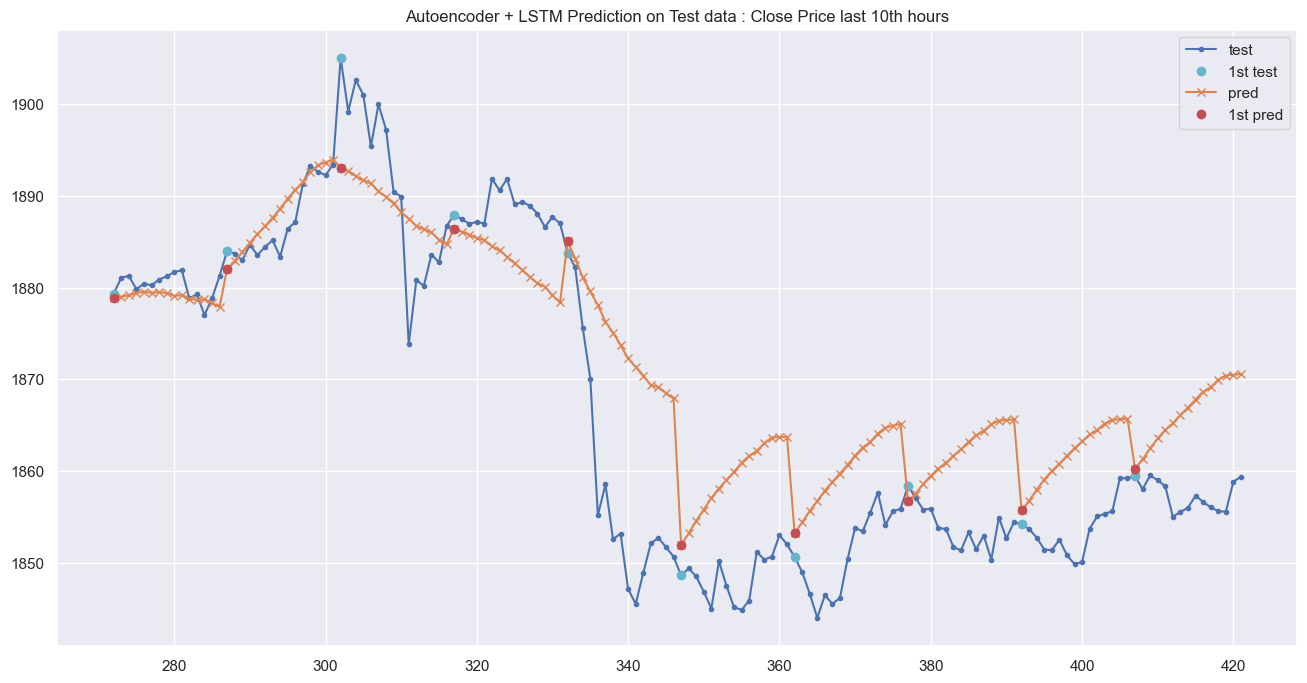

In [411]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Test data : Close Price last 10th hours")
nb_pred = 10
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')

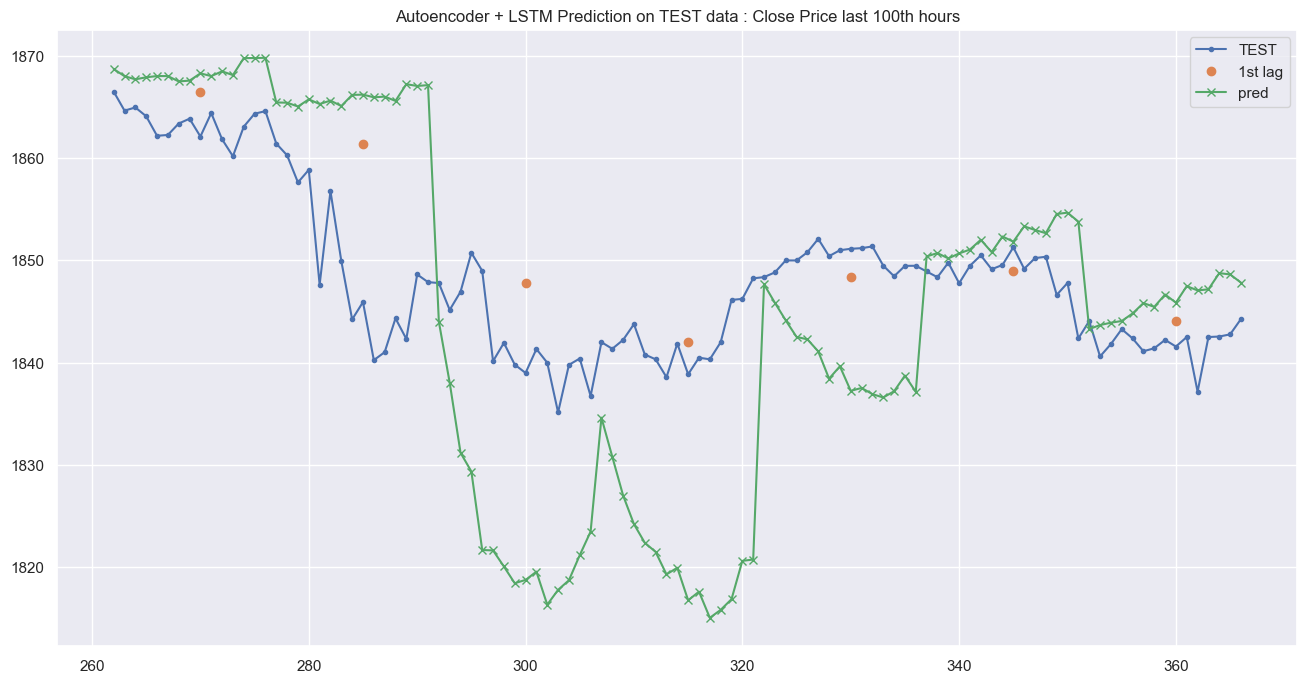

In [177]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
nb_pred = 7
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="TEST")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [178]:
np.array(range(0,y_test_raw.shape[0], FUTURE_TARGET))

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [179]:
y_test_raw[range(0,y_test_raw.shape[0], FUTURE_TARGET),:]

array([[1826.02, 1833.11, 1831.72, 1836.5 , 1834.53, 1835.42, 1833.77,
        1836.26, 1838.49, 1838.75, 1841.12, 1838.2 , 1836.28, 1836.76,
        1836.99],
       [1838.  , 1839.84, 1841.12, 1842.13, 1840.16, 1842.22, 1848.2 ,
        1846.55, 1845.46, 1844.  , 1847.21, 1845.48, 1844.46, 1844.73,
        1847.74],
       [1847.01, 1855.73, 1863.66, 1860.38, 1859.41, 1865.73, 1864.87,
        1861.95, 1884.27, 1876.86, 1880.02, 1877.13, 1874.8 , 1874.83,
        1875.11],
       [1874.72, 1874.93, 1875.76, 1875.84, 1876.33, 1876.8 , 1873.94,
        1874.77, 1874.59, 1874.31, 1873.29, 1874.75, 1874.87, 1873.95,
        1874.57],
       [1873.5 , 1880.12, 1881.28, 1879.31, 1880.36, 1880.74, 1882.25,
        1895.9 , 1891.82, 1890.59, 1889.69, 1888.71, 1883.59, 1879.64,
        1881.59],
       [1879.38, 1878.81, 1874.59, 1877.21, 1877.44, 1876.58, 1879.32,
        1877.88, 1880.55, 1879.54, 1878.45, 1877.5 , 1875.8 , 1876.36,
        1879.1 ],
       [1878.76, 1880.99, 1879.67, 1878.

In [180]:
y_test_raw[:,0]

array([1826.02, 1833.11, 1831.72, 1836.5 , 1834.53, 1835.42, 1833.77,
       1836.26, 1838.49, 1838.75, 1841.12, 1838.2 , 1836.28, 1836.76,
       1836.99, 1838.  , 1839.84, 1841.12, 1842.13, 1840.16, 1842.22,
       1848.2 , 1846.55, 1845.46, 1844.  , 1847.21, 1845.48, 1844.46,
       1844.73, 1847.74, 1847.01, 1855.73, 1863.66, 1860.38, 1859.41,
       1865.73, 1864.87, 1861.95, 1884.27, 1876.86, 1880.02, 1877.13,
       1874.8 , 1874.83, 1875.11, 1874.72, 1874.93, 1875.76, 1875.84,
       1876.33, 1876.8 , 1873.94, 1874.77, 1874.59, 1874.31, 1873.29,
       1874.75, 1874.87, 1873.95, 1874.57, 1873.5 , 1880.12, 1881.28,
       1879.31, 1880.36, 1880.74, 1882.25, 1895.9 , 1891.82, 1890.59,
       1889.69, 1888.71, 1883.59, 1879.64, 1881.59, 1879.38, 1878.81,
       1874.59, 1877.21, 1877.44, 1876.58, 1879.32, 1877.88, 1880.55,
       1879.54, 1878.45, 1877.5 , 1875.8 , 1876.36, 1879.1 , 1878.76,
       1880.99, 1879.67, 1878.99, 1878.8 , 1879.83, 1878.01, 1878.77,
       1878.52, 1880

In [264]:
y_test_raw[0::FUTURE_TARGET,:].ravel()

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [253]:
y_test_raw[0::FUTURE_TARGET,:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [251]:
y_test_raw[-13:, :]

array([[1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01],
       [1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63,
        1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 1789.42],
       [1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53,
        1804.62, 1804.21, 1797.69, 1795.01, 1789.42, 1785.56],
       [1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62,
        1804.21, 1797.69, 1795.01, 1789.42, 1785.56, 1770.18],
       [1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21,
        1797.69, 1795.01, 1789.42, 1785.56, 1770.18, 1776.6 ],
       [1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69,
        1795.01, 1789.42, 1785.56, 1770.18, 1776.6 , 1781.62],
       [1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01,
        1789.42, 1785.56, 1770.18, 1776.6 , 1781.62, 1795.23],
       [1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 

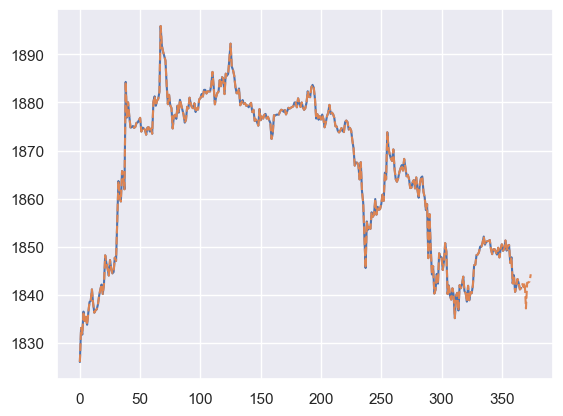

In [181]:
plt.plot(y_test_raw[:,0])
plt.plot(y_test_raw[0::FUTURE_TARGET,:].ravel(),'--')

In [182]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1842.38 1841.12 1841.41 1842.23 1841.58 1842.51 1837.16 1842.51 1842.56
 1842.77 1844.27 1841.51 1836.51 1836.16 1837.79]
[1844.26287957 1844.87704197 1845.73686933 1845.96737249 1846.58922565
 1847.64857339 1847.67933644 1848.54421773 1847.79799394 1849.397453
 1849.36910705 1849.38976224 1850.21816733 1850.17553853 1848.90458493]


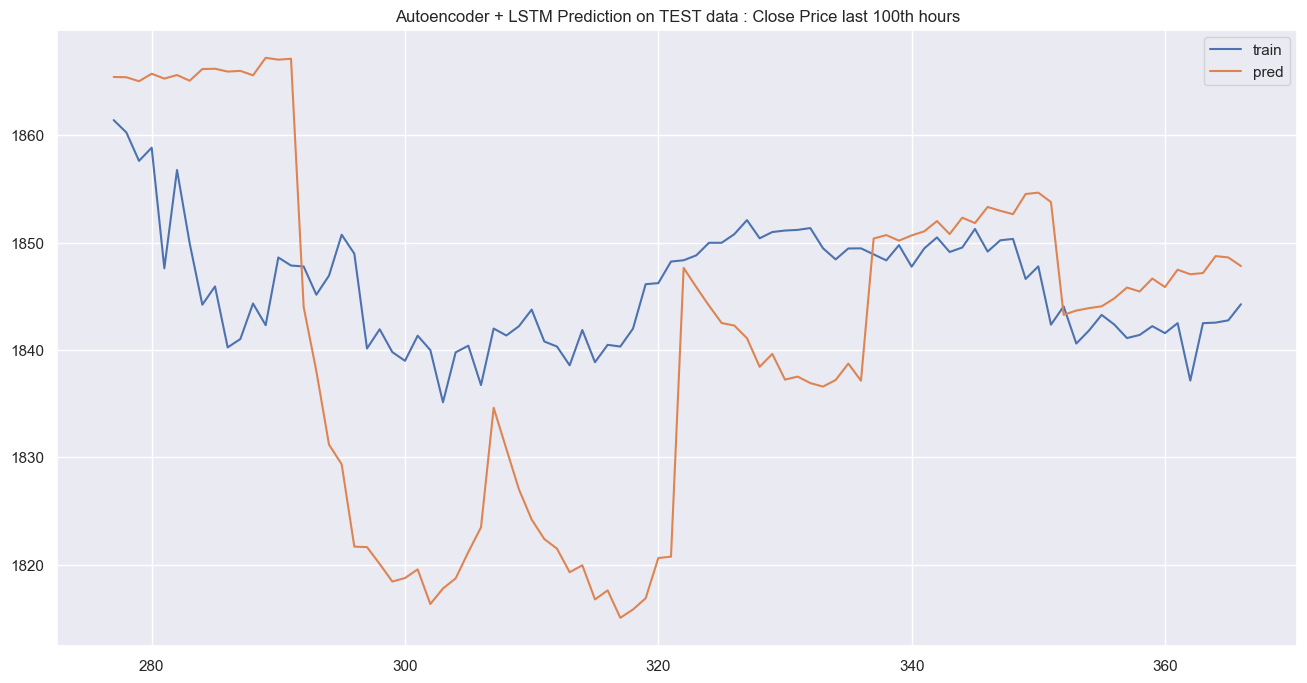

In [183]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
x_axis = np.array(range(y_test_raw.shape[0]))
plt.plot(x_axis[-90:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="train")
plt.plot(x_axis[-90:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="pred")
plt.legend(loc='upper right')

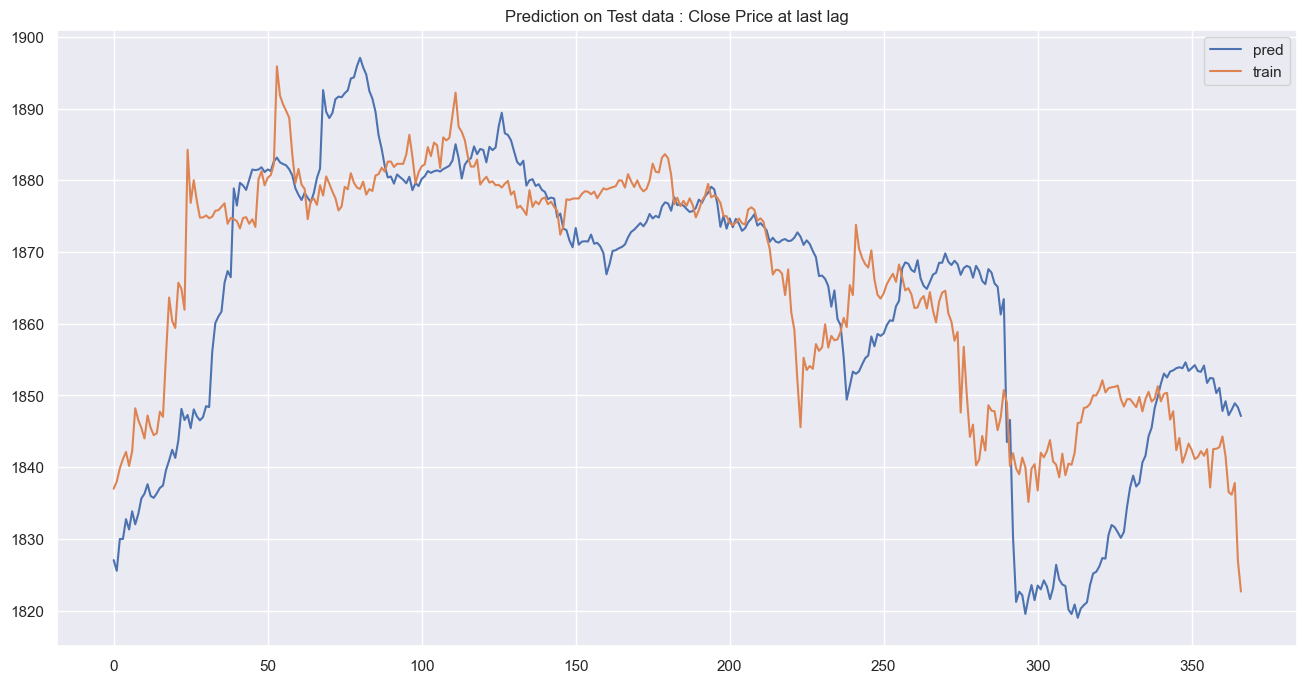

In [184]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

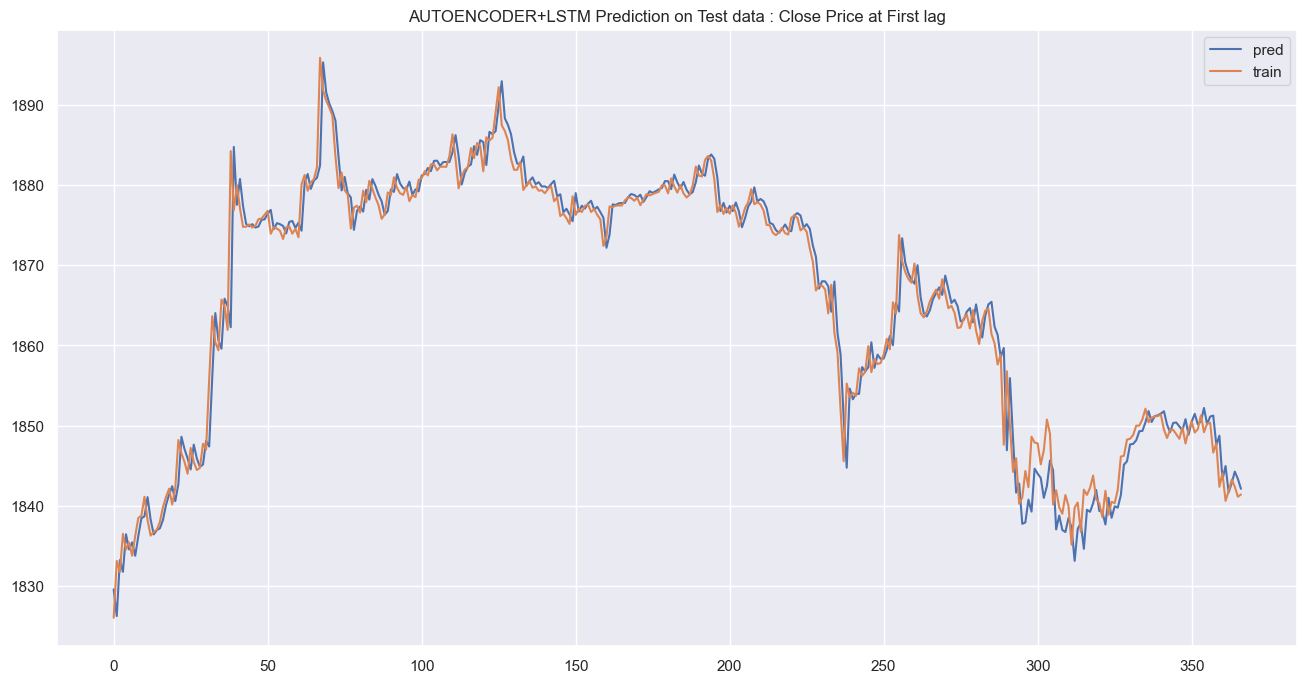

In [185]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

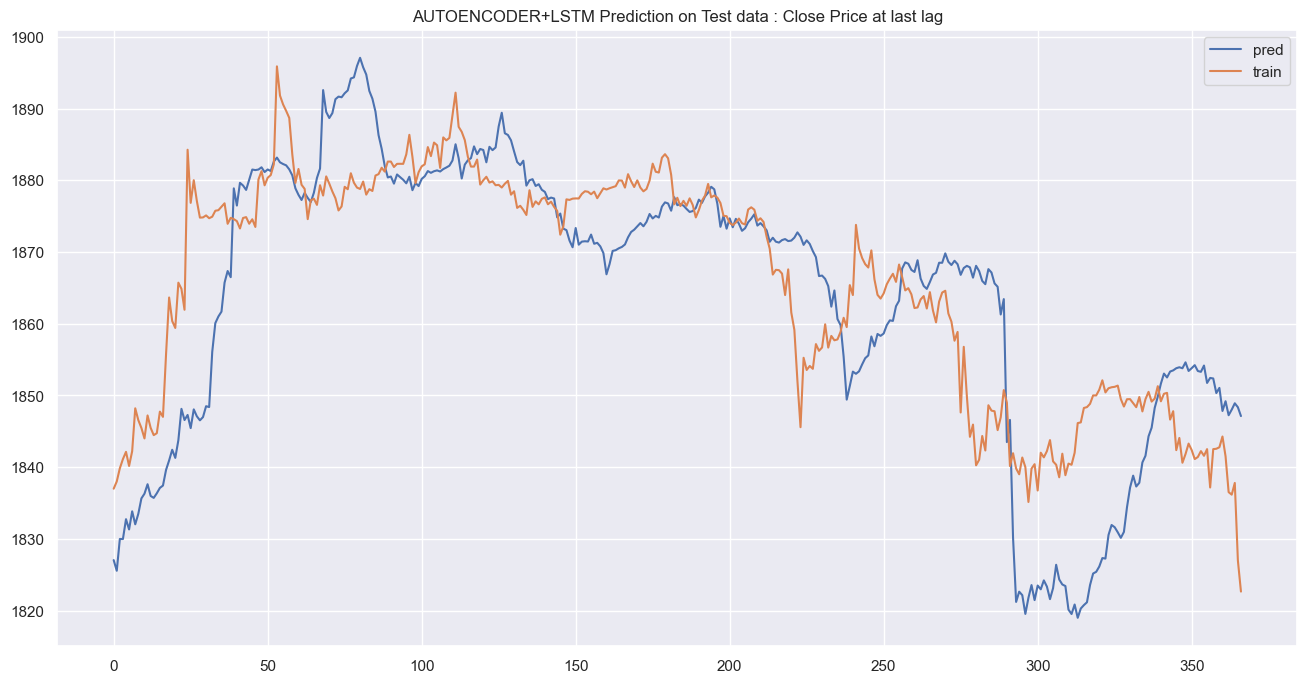

In [186]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [125]:
str(time.time())

'1680725792.947519'

## Predict last prediction

In [281]:
X_test_sca.shape

(367, 72, 104)

In [282]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [283]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [284]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale py ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate
X_last_ = np.concatenate([X_last_sca[:,:,0:4], X_last_encoded_sca], axis=-1)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))

[batch, lags, features]
X_last[0,:,0]:
[1848.83 1850.   1850.   1850.8  1852.11 1850.42 1851.   1851.14 1851.2
 1851.37 1849.49 1848.45 1849.47 1849.48 1848.92 1848.36 1849.78 1847.77
 1849.48 1850.5  1849.14 1849.56 1851.29 1849.18 1850.23 1850.36 1846.63
 1847.8  1842.37 1844.07 1840.61 1841.82 1843.28 1842.38 1841.12 1841.41
 1842.23 1841.58 1842.51 1837.16 1842.51 1842.56 1842.77 1844.27 1841.51
 1836.51 1836.16 1837.79 1826.99 1822.64 1826.2  1829.21 1832.05 1832.81
 1829.78 1827.84 1829.23 1828.59 1828.43 1830.26 1830.27 1829.72 1831.39
 1829.71 1827.1  1829.78 1830.63 1830.41 1833.   1831.74 1832.33 1832.77]
X_last[0,:,0] after divide by price:
[1.00876269 1.00940107 1.00940107 1.00983757 1.01055233 1.00963023
 1.00994669 1.01002308 1.01005582 1.01014857 1.0091228  1.00855536
 1.00911189 1.00911735 1.0088118  1.00850625 1.00928103 1.00818433
 1.00911735 1.00967388 1.00893184 1.009161   1.01010492 1.00895366
 1.00952656 1.00959749 1.00756232 1.0082007  1.00523797 1.00616553
 1.00

In [285]:
PAST_HISTORY

72

In [286]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
45497  1686180300000   1830.63   1830.83  1829.89    1830.41    406.3064   
45498  1686180600000   1830.41   1833.00  1830.25    1833.00    500.6436   
45499  1686180900000   1833.00   1833.00  1831.00    1831.74    625.5965   
45500  1686181200000   1831.75   1832.33  1830.86    1832.33    367.2071   
45501  1686181500000   1832.33   1833.00  1831.77    1832.77    437.6968   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1710.244864       1709.520092   
1      2023-01-01 00:05:00       1710.244864       1709.520092   
2      2023-01-01 00:10:00       1710.244864       1709.520092   
3      2023-01-01 00:15:00       1710.244864       1709.520092   
4      2023-01-01 00:20:00       1710.244864       1709.520092   
...                    ...               ...               ...   
45497  2023-06-07 23:25:00       1839.040000       1841.440000   
45498  2023-06-07 23:30:00       1839.092500       1841.440000   
45499  2023-06-07 23:35:00       1839.202500       1841.440000   
45500  2023-06-07 23:40:00       1839.202500       1841.440000   
45501  2023-06-07 23:45:00       1839.202500       1841.440000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
45497        1832.730  ...         NaN            NaN           NaN   
45498        1832.730  ...         NaN            NaN           NaN   
45499        1832.730  ...         NaN            NaN           NaN   
45500        1831.345  ...         NaN            NaN           NaN   
45501        1829.520  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
45497               NaN         0.0               NaN         0.0      0.0   
45498               NaN         0.0               NaN         0.0      0.0   
45499               NaN         0.0               NaN         0.0      0.0   
45500               NaN         0.0               NaN         0.0      0.0   
45501               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
45497                  NaN  False  
45498                  NaN  False  
45499                  NaN  False  
45500                  NaN  False  
45501                  NaN  False  

[45502 rows x 136 columns]

In [287]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [288]:
y_last_pred_unscaled

array([[1.0002449 , 1.0002517 , 1.0007257 , 1.0007071 , 1.0007714 ,
        1.0013181 , 1.0008879 , 1.0009604 , 1.0006955 , 1.0007404 ,
        1.0003047 , 1.000313  , 0.99988055, 1.0000594 , 1.0008612 ]],
      dtype=float32)

In [289]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [290]:
y_last_pred_raw

array([[1833.2188, 1833.2312, 1834.1001, 1834.066 , 1834.1838, 1835.1858,
        1834.3973, 1834.5302, 1834.0447, 1834.1271, 1833.3285, 1833.3438,
        1832.5511, 1832.8788, 1834.3484]], dtype=float32)

In [291]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [292]:
list_pred

[1834.066,
 1834.1838,
 1835.1858,
 1834.3973,
 1834.5302,
 1834.0447,
 1834.1271,
 1833.3285,
 1833.3438,
 1832.5511,
 1832.8788,
 1834.3484]

In [293]:
save_list(list_pred, path_save_pred_vals)

In [294]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [295]:
list_pred_reload

[1834.066,
 1834.1838,
 1835.1858,
 1834.3973,
 1834.5302,
 1834.0447,
 1834.1271,
 1833.3285,
 1833.3438,
 1832.5511,
 1832.8788,
 1834.3484]